# Setup the environment

In [1]:
%%capture
!pip install epigenomic_dataset
!pip install ucsc_genomes_downloader
!pip install pytest
!pip install pytest-ipynb
!pip install tqdm
!pip install boruta
!pip install mrmr_selection
!pip install minepy
!pip install keras_bed_sequence
!pip install extra_keras_metrics
!pip install keras_tuner
!pip install plot-keras-history
!pip install barplots
!pip install seaborn
!pip install hypopt --upgrade

In [1]:
import numpy as np
import pandas as pd
import pickle
import os
from os import cpu_count
from tqdm.auto import tqdm
from epigenomic_dataset import active_promoters_vs_inactive_promoters
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers
from epigenomic_dataset.utils import normalize_epigenomic_data
from ucsc_genomes_downloader import Genome
import matplotlib.pyplot as plt
from cache_decorator import Cache
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold
import random
import seaborn as sns
#from minepy import MINE
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics.pairwise import euclidean_distances
from mrmr import mrmr_regression, mrmr_classif
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from boruta import BorutaPy
from multiprocessing import cpu_count
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from keras_bed_sequence import BedSequence
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from matplotlib.colors import ListedColormap, LogNorm
from scipy.stats import spearmanr
from scipy.stats import entropy
from scipy.stats import pearsonr
from scipy.stats import wilcoxon
from typing import Tuple
from typing import Optional
import tensorflow as tf
from hypopt import GridSearch

#Comment in case of No GPU
#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
#physical_devices = tf.config.list_physical_devices("GPU")
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer
from tensorflow.keras.layers import Conv1D, MaxPool1D, AveragePooling1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from extra_keras_metrics import get_complete_binary_metrics
from keras_mixed_sequence import MixedSequence, VectorSequence
from keras_bed_sequence import BedSequence
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
import keras_tuner as kt
from tensorflow.keras.optimizers import Nadam
from plot_keras_history import plot_history
from barplots import barplots
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from keras.engine.functional import Functional

In [54]:
cell_line = "A549"
assembly = "hg38" 
window_size = 256

# Data retrivial and pre-processing

### Retrieving data from epigenomic_dataset and UCSC genome browser

For retrieving epigenomic data we used the methods
*   active_promoters_vs_inactive_promoters
*   active_enhancers_vs_inactive_enhancers

In both cases we considered a window_size=256 and used metric='mean' in order to take into account the noiseness of epigenomic data.


In [55]:
def load_epigenomes(cell_line, assembly, window_size):
    epigenomes = {
        "promoters": {},
        "enhancers": {}
    }

    labels = {
        "promoters": {},
        "enhancers": {}
    }

    epigenomes["promoters"], labels["promoters"] =\
        active_promoters_vs_inactive_promoters(
            cell_line = cell_line,
            assembly = assembly,
            dataset = "fantom",
            window_size = window_size,
            root = "datasets",
            metric='mean'
        )

    epigenomes["enhancers"], labels["enhancers"] =\
        active_enhancers_vs_inactive_enhancers(
            cell_line = cell_line,
            assembly = assembly,
            dataset = "fantom",
            window_size = window_size,
            root = "datasets",
            metric='mean'
        )
    return epigenomes,labels

In [56]:
epigenomes, labels = load_epigenomes(cell_line = cell_line, 
                                     assembly = assembly, 
                                     window_size = window_size)

In [57]:
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

In [58]:
genome = Genome(assembly)
genome

Loading chromosomes for genome hg38:   0%|          | 0/25 [00:00<?, ?it/s]

Human, Homo sapiens, hg38, 2013-12-30, 25 chromosomes

### Imputation of NaN values in Epigenomic data

In [59]:
# NaN values report

for region, x in epigenomes.items():
    print("\n".join((
        f"Nan values report for {region} data:",
        f"In the document there are {x.isna().values.sum()} NaN values out of {x.values.size} values.",
        f"The sample (row) with most values has {x.isna().sum(axis=0).max()} NaN values out of {x.shape[1]} values.",
        f"The feature (column) with most values has {x.isna().sum().max()} NaN values out of {x.shape[0]} values."
    )))
    print("="*80)

Nan values report for promoters data:
In the document there are 372 NaN values out of 4794288 values.
The sample (row) with most values has 189 NaN values out of 48 values.
The feature (column) with most values has 189 NaN values out of 99881 values.
Nan values report for enhancers data:
In the document there are 32 NaN values out of 3037680 values.
The sample (row) with most values has 32 NaN values out of 48 values.
The feature (column) with most values has 32 NaN values out of 63285 values.


In [60]:
def knn_imputer(df:pd.DataFrame, neighbours:int=5)->pd.DataFrame:
    """Fill nan values within given dataframe using a k-NN imputer.

    Parameters
    ------------------------
    df:pd.DataFrame,
        The dataframe to fill up.

    neighbours:int,
        The number of neighbours that the k-NN imputer will consider.
        
    Returns
    ------------------------
    Return the dataframe with the imputed values.
    """

    return pd.DataFrame(
        KNNImputer(n_neighbors=neighbours).fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [61]:
#Imputation
epigenomes['promoters'] = knn_imputer(epigenomes['promoters'])
epigenomes['enhancers'] = knn_imputer(epigenomes['enhancers'])

### Rate between features and #samples

In [62]:
for region, x in epigenomes.items():
    print(
    f"The rate between features and samples for {region} data is: {x.shape[0]/x.shape[1]}"
    )
    print("="*80)

The rate between features and samples for promoters data is: 2080.8541666666665
The rate between features and samples for enhancers data is: 1318.4375


### Dropping costant features

In [63]:
def drop_constant_features(df:pd.DataFrame)->pd.DataFrame:
    """Return DataFrame without constant features. 
    
    Parameters
    ------------------------
    df:pd.DataFrame
        
    Returns
    ------------------------
    Return the dataframe with the dropped features."""

    return df. loc[:, (df != df.iloc[0]).any()]

In [64]:
for region, x in epigenomes.items():
    result = drop_constant_features(x)
    if x.shape[1] != result.shape[1]:
        print(f"Features in {region} were constant and had to be dropped!")
        epigenomes[region] = result
    else:
        print(f"No constant features were found in {region}!")

No constant features were found in promoters!
No constant features were found in enhancers!


### Robust Scaling

Please note that this is a propredeutic step for Feature Selection and PCA/t-SNE visualizations. <br> When realizing the holdouts we will repeat Robust scaling on Training Set and then transform the Test Set in order to avoid any data leakage.

In [65]:
def robust_zscoring(df:pd.DataFrame)->pd.DataFrame:
    """Rescale dataframe values by using robust z-scoring.

    Parameters
    ------------------------
    df:pd.DataFrame,
        The dataframe to apply robust z-scaling.
        
    Returns
    ------------------------
    Return the scaled dataframe.
    """
    return pd.DataFrame(
        RobustScaler().fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [66]:
# Dictionary comprehension
epigenomes = {
    region: robust_zscoring(x) for region, x in epigenomes.items()
}

### Labels clipping

Outliers can influence negatively our analysis, so we decided to clip label values to the .99 quantile for both promoters and enahncers.

In [67]:
quantile_99_promoters = np.ceil(np.quantile(labels['promoters'], q=0.99))
quantile_99_enhancers = np.ceil(np.quantile(labels['enhancers'], q=0.99))

In [68]:
labels['promoters'][labels['promoters']>quantile_99_promoters] = quantile_99_promoters
labels['enhancers'][labels['enhancers']>quantile_99_enhancers] = quantile_99_enhancers

### Binarization of labels

The labels data of both promoters and enhancers regions seem to follow an exponential distribution, as we can notice from the plots the ranges of the two regions are extremely different.

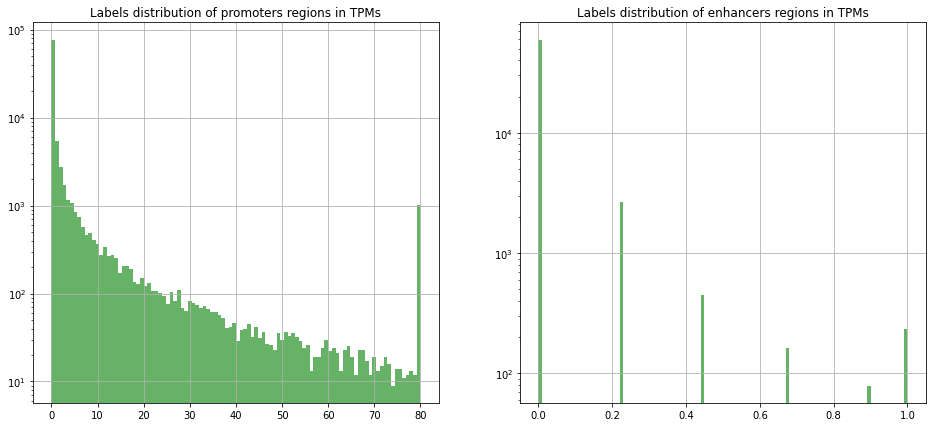

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(16,7))
for i, region in enumerate(labels.items()):
    region[1][cell_line].hist(log=True, 
                           ax=axes[i],
                           bins=100,
                           alpha=0.6, 
                           color='green')
    axes[i].set_title(f"Labels distribution of {region[0]} regions in TPMs")

What would happen if we chose a threshold of 1.0 (>=) for both enhancers and promoters and dropping labels between 0.0 and 1.0?

In [70]:
tentative_binarized_labels = {
    "promoters": {},
    "enhancers": {}
}
tentative_labels = {
    "promoters": {},
    "enhancers": {}
}

tentative_labels['enhancers'] = labels['enhancers'][(labels['enhancers'] <= 0.0 ) | (labels['enhancers'] >= 1.0)].dropna()
tentative_labels['promoters'] = labels['promoters'][(labels['promoters'] <= 0.0 ) | (labels['promoters'] >= 1.0)].dropna()

tentative_binarized_labels['promoters'] = labels['promoters']  >= 1.0 
tentative_binarized_labels['enhancers'] = labels['enhancers']  >= 1.0

In [71]:
print(f" The Imbalance ratio of promoters data would be {len(tentative_binarized_labels['promoters'][tentative_binarized_labels['promoters']==False].dropna()) /len(tentative_binarized_labels['promoters'][tentative_binarized_labels['promoters']==True].dropna()) } ")
print(f" The Imbalance ratio of enhancers data would be {len(tentative_binarized_labels['enhancers'][tentative_binarized_labels['enhancers']==False].dropna()) /len(tentative_binarized_labels['enhancers'][tentative_binarized_labels['enhancers']==True].dropna()) } ") 

 The Imbalance ratio of promoters data would be 3.9016538253913726 
 The Imbalance ratio of enhancers data would be 270.6094420600858 


The Imbalance ratio of enhancers data would be too high to do something, thus we choose to not drop any label and proceed considering a threshold 1.0 for promoters and a tentative threshold 0.0 for enhancers

In [72]:
binarized_labels = {
    "promoters": {},
    "enhancers": {}
}

binarized_labels['promoters'] = labels['promoters']  > 1.0
binarized_labels['enhancers'] = labels['enhancers']  > 0.0

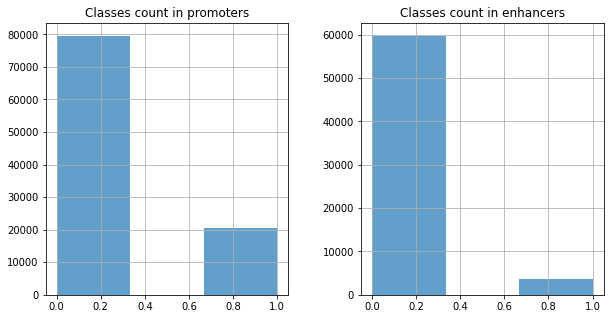

In [73]:
#The threshold 1.0 is used to distinguish between active and inactive promoters/enancher
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

for axis, (region, y) in zip(axes.ravel(), binarized_labels.items()):
    (y).astype(int).hist(ax=axis, bins=3, alpha=0.7)
    axis.set_title(f"Classes count in {region}")
fig.show()

In [74]:
print(f" The Imbalance ratio of promoters is {len(binarized_labels['promoters'][binarized_labels['promoters']==False].dropna()) /len(binarized_labels['promoters'][binarized_labels['promoters']==True].dropna()) } ")
print(f" The Imbalance ratio of enhancers is {len(binarized_labels['enhancers'][binarized_labels['enhancers']==False].dropna()) /len(binarized_labels['enhancers'][binarized_labels['enhancers']==True].dropna()) } ") 

 The Imbalance ratio of promoters is 3.9016538253913726 
 The Imbalance ratio of enhancers is 16.564529558701082 


In this way, the enhancers dataset is certainly more learnable.

# Feature Analysis
In this section we analyze features correlations, plot their distributions and employ Feature Selection techniques.

### Feature Correlations
In this step we search for features that are not correlated at all with the output and features that are highly correlated with each other, by performing correlation tests (Pearson and Spearman) . <br>

*Searching for uncorrelated with output features, usually features that are not correlated with the output are not useful*

In [75]:
p_value_threshold = 0.01 #if the pvalue is greater than 0.01 the correlation is not statistically significant
correlation_threshold = 0.05

uncorrelated = {
    region: set()
    for region in epigenomes
}

In [76]:
for region, x in epigenomes.items():
    for column in tqdm(x.columns, desc=f"Running Pearson test for {region}", dynamic_ncols=True, leave=False):
        correlation, p_value = pearsonr(x[column].values.ravel(), labels[region].values.ravel())
        if p_value > p_value_threshold and correlation < correlation_threshold:
            uncorrelated[region].add(column)

Running Pearson test for promoters:   0%|          | 0/48 [00:00<?, ?it/s]

Running Pearson test for enhancers:   0%|          | 0/48 [00:00<?, ?it/s]

In [77]:
for region, x in epigenomes.items():
    for column in tqdm(x.columns, desc=f"Running Spearman test for {region}", dynamic_ncols=True, leave=False):
        correlation, p_value = spearmanr(x[column].values.ravel(), labels[region].values.ravel())
        if p_value > p_value_threshold and correlation < correlation_threshold:
            uncorrelated[region].add(column)

Running Spearman test for promoters:   0%|          | 0/48 [00:00<?, ?it/s]

Running Spearman test for enhancers:   0%|          | 0/48 [00:00<?, ?it/s]

In [78]:
uncorrelated

{'promoters': {'FOSB', 'ZC3H11A'}, 'enhancers': {'CBX2', 'KDM5A', 'ZC3H11A'}}

*Searching for extremely correlated with each other features*

In [79]:
p_value_threshold = 0.01 # if the p-value is lower than 0.01 we reject null hypothesis
correlation_threshold = 0.85

In [80]:
extremely_correlated = {
    region: set()
    for region in epigenomes
}

scores = {
    region: []
    for region in epigenomes
}

for region, x in epigenomes.items():
    for i, column in tqdm(
        enumerate(x.columns),
        total=len(x.columns), desc=f"Running Pearson test for {region}", dynamic_ncols=True, leave=False):
        for feature in x.columns[i+1:]:
            correlation, p_value = pearsonr(x[column].values.ravel(), x[feature].values.ravel())
            correlation = np.abs(correlation)
            scores[region].append((correlation, column, feature))
            if p_value < p_value_threshold and correlation > correlation_threshold:
                print(region, column, feature, correlation)
                
                #The less relevant feature is the one with the lower Entropy
                if entropy(x[column]) > entropy(x[feature]):
                    extremely_correlated[region].add(feature)
                else:
                    extremely_correlated[region].add(column)

Running Pearson test for promoters:   0%|          | 0/48 [00:00<?, ?it/s]

Running Pearson test for enhancers:   0%|          | 0/48 [00:00<?, ?it/s]

In [81]:
extremely_correlated

{'promoters': set(), 'enhancers': set()}

*Running MIC on features that we are about to discard, in this case only on features uncorrelated with the output*

In [ ]:
#MIC is extremely computationally expensive so we want to use it only on the features we are about to discard
#because they seem to be not correlated at all with the output

for region, x in epigenomes.items():
    for column in tqdm(uncorrelated[region], desc=f"Running MINE test for {region}", dynamic_ncols=True, leave=False):
        mine = MINE()
        mine.compute_score(x[column].values.ravel(), labels[region].values.ravel())
        score = mine.mic()
        if score < correlation_threshold:
            print(region, column, score)
        else:
            uncorrelated[region].remove(column)

Running MINE test for promoters:   0%|          | 0/2 [00:00<?, ?it/s]

promoters ZC3H11A 0.005917489866374574
promoters FOSB 0.00725046465852653


Running MINE test for enhancers:   0%|          | 0/3 [00:00<?, ?it/s]

enhancers ZC3H11A 0.004149480891048051
enhancers CBX2 0.004156836908438352
enhancers KDM5A 0.006562641217737903


In [ ]:
uncorrelated

{'enhancers': {'CBX2', 'KDM5A', 'ZC3H11A'}, 'promoters': {'FOSB', 'ZC3H11A'}}

*Scatter plots for showing correlations between features*

In [82]:
scores = {
    region:sorted(score, key=lambda x: np.abs(x[0]), reverse=True)
    for region, score in scores.items()
}

Most correlated features from promoters epigenomes


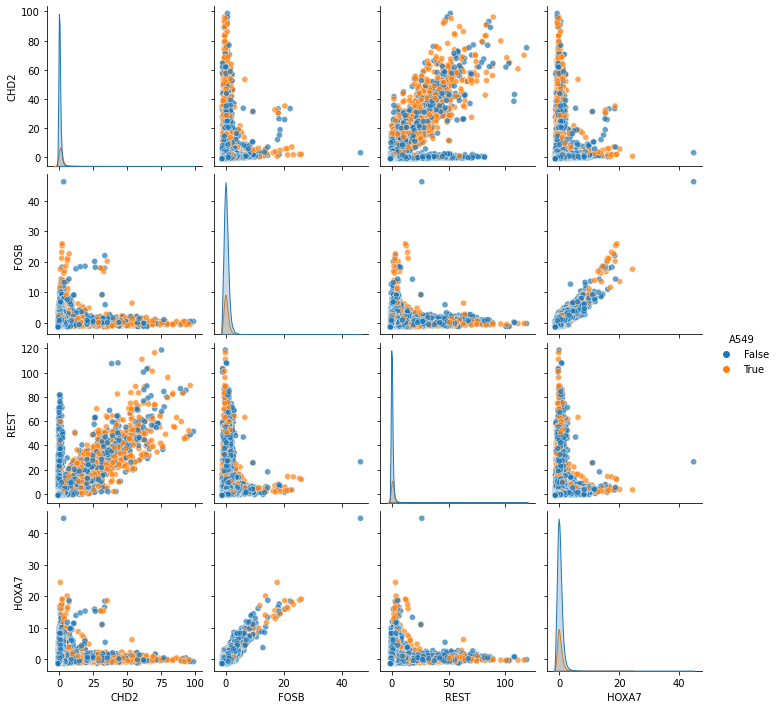

Most correlated features from enhancers epigenomes


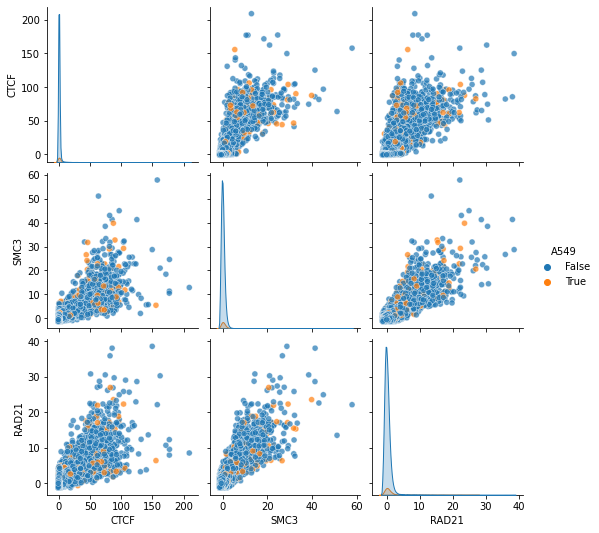

In [83]:
for region, x in epigenomes.items():
    _, firsts, seconds = list(zip(*scores[region][:2]))
    columns = list(set(firsts+seconds))
    print(f"Most correlated features from {region} epigenomes")

    sns.pairplot(
      pd.concat([
          x[columns],
          binarized_labels[region],
      ], axis=1), 
      hue=binarized_labels[region].columns[0],
      plot_kws={'alpha':0.7} 
    )
    plt.show()

### Features Distributions

Top 5 different features from promoters.


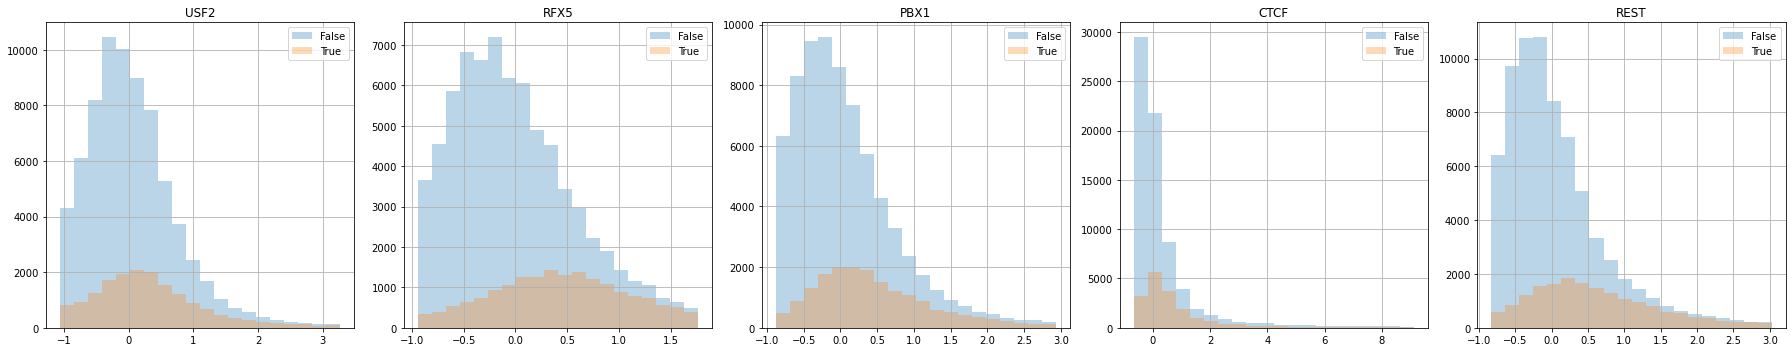

Top 5 different features from enhancers.


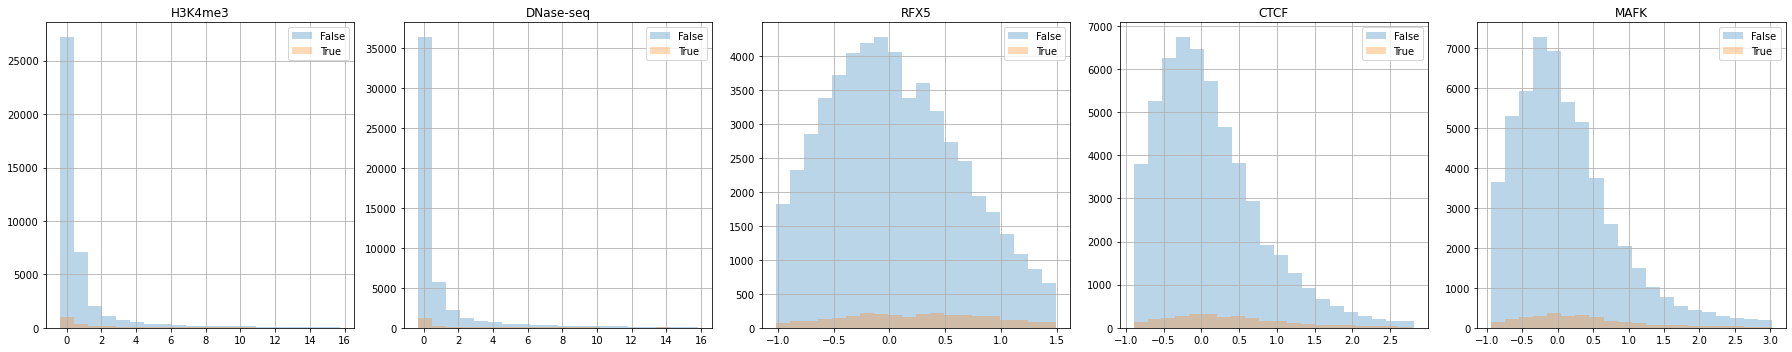

In [165]:
def get_top_most_different(dist, n:int):
    return np.argsort(-np.mean(dist, axis=1).flatten())[:n]

top_number = 5

for region, x in epigenomes.items():
    dist = euclidean_distances(x.T)
    most_distance_columns_indices = get_top_most_different(dist, top_number)
    columns = x.columns[most_distance_columns_indices]
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
    print(f"Top {top_number} different features from {region}.")

    for column, axis in zip(columns, axes.flatten()):
        head, tail = x[column].quantile([0.05, 0.95]).values.ravel()
        
        mask = ((x[column] < tail) & (x[column] > head)).values
        
        cleared_x = x[column][mask]
        cleared_y = binarized_labels[region].values.ravel()[mask]

        for bin_value in np.unique(binarized_labels[region]):
            cleared_x[cleared_y==bin_value].hist(ax=axis, bins=20, alpha = 0.3)
        axis.legend(np.unique(binarized_labels[region]))

        axis.set_title(column)
    fig.tight_layout()
    plt.show()

*Dropping unrelevant features*

None of the features uncorrelated with the output exhibit a non linear correlation according to the MINE test. Thus, we can proceed by discarding those.

In [ ]:
#Dropping uncorrelated with the output features
for region, x in epigenomes.items():
    epigenomes[region] =x.drop(columns=[
        col
        for col in uncorrelated[region]
        if col in x.columns
    ])

 ### Feature Selection (Boruta and mRMR)

In [128]:
def execute_boruta(X: pd.DataFrame, y: pd.DataFrame, n_iter: int):
    boruta_selector = BorutaPy(
            # Defining the model that Boruta should use.
            RandomForestClassifier(n_jobs=cpu_count(), class_weight='balanced_subsample', max_depth=5),
            # We leave the number of estimators to be decided by Boruta
            n_estimators='auto',
            verbose=1,
            alpha=0.05, # p_value threshold
            max_iter=n_iter, 
            random_state=42,
    )
    boruta_selector.fit(X.values, y)
    return list(X.columns[boruta_selector.support_])

def execute_mrmr(X: pd.DataFrame, y: pd.DataFrame, n_features: int):
    return mrmr_classif(X = X, 
                        y = y,
                        K = n_features,
                        relevance='f')

*Running a repeated holdout procedure to search for stable features*

In [ ]:
#Dictionaries to keep the selected features over the various holdouts
holdouts_boruta_features = {'promoters': [],
                            'enhancers':[]}

holdouts_mrmr_features = {'promoters': [], 
                          'enhancers':[]}

for region, x in tqdm(epigenomes.items(), desc = f"Running 5-Stratified Shuffle Split for searching the best features for {region} regions"):
    
    sss = StratifiedShuffleSplit(n_splits=5, train_size=0.8, test_size=0.2,random_state=42)
    
    for train_index, _ in sss.split(x, binarized_labels[region]):
        
        #Let's index our dataframe and extract the current split data
        holdout_x = x.iloc[train_index]
        holdout_y = binarized_labels[region].iloc[train_index]
        
        print('Running boruta feature selection')
        boruta_features = execute_boruta(X = holdout_x, y = holdout_y, n_iter = 100)
        
        print('Running mRMR feature selection')
        mrmr_features = execute_mrmr(X = holdout_x, y = holdout_y, n_features = len(boruta_features))
        
        holdouts_boruta_features[region].append( boruta_features)
        holdouts_mrmr_features[region].append( mrmr_features)

Running 5-Stratified Shuffle Split for searching the best features for enhancers regions:   0%|          | 0/2…

Running boruta feature selection
Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	46
Tentative: 	0
Rejected: 	0
Running mRMR feature selection



100%|██████████| 46/46 [00:10<00:00,  4.33it/s]


Running boruta feature selection
Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	46
Tentative: 	0
Rejected: 	0
Running mRMR feature selection



100%|██████████| 46/46 [00:10<00:00,  4.33it/s]


Running boruta feature selection
Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	46
Tentative: 	0
Rejected: 	0
Running mRMR feature selection



100%|██████████| 46/46 [00:10<00:00,  4.41it/s]


Running boruta feature selection
Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	46
Tentative: 	0
Rejected: 	0
Running mRMR feature selection



100%|██████████| 46/46 [00:10<00:00,  4.48it/s]


Running boruta feature selection
Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	46
Tentative: 	0
Rejected: 	0
Running mRMR feature selection



100%|██████████| 46/46 [00:10<00:00,  4.49it/s]


Running boruta feature selection
Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 


100%|██████████| 41/41 [00:08<00:00,  4.87it/s]


Running boruta feature selection
Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 


100%|██████████| 40/40 [00:08<00:00,  4.83it/s]


Running boruta feature selection
Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 


100%|██████████| 42/42 [00:08<00:00,  4.94it/s]


Running boruta feature selection
Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 


100%|██████████| 39/39 [00:08<00:00,  4.75it/s]


Running boruta feature selection
Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 


100%|██████████| 40/40 [00:08<00:00,  4.84it/s]


In promoters data Boruta and mRMR methods do not select any feature subset (they allways select all the features)  over the 5 stratified holdouts.
Thus, we proceed considering no feature selection for promoters data.

In [ ]:
set(holdouts_boruta_features['promoters'][0]) == \
set(holdouts_boruta_features['promoters'][1]) == \
set(holdouts_boruta_features['promoters'][2]) == \
set(holdouts_boruta_features['promoters'][3]) == \
set(holdouts_boruta_features['promoters'][4]) == \
set(holdouts_mrmr_features['promoters'][0]) == \
set(holdouts_mrmr_features['promoters'][1]) == \
set(holdouts_mrmr_features['promoters'][2]) == \
set(holdouts_mrmr_features['promoters'][3]) == \
set(holdouts_mrmr_features['promoters'][4])

True

The sets of selected features by Boruta and mRMR in the enhancers data are almost stable over the 5 stratified holdouts. 35 features are allways present, over a max cardinality of 42. Thus, we proceed considering the intersection of the sets as selected features.

In [ ]:
intersection = set.intersection( set(holdouts_boruta_features['enhancers'][0]),
                      set(holdouts_boruta_features['enhancers'][1]),
                      set(holdouts_boruta_features['enhancers'][2]),
                      set(holdouts_boruta_features['enhancers'][3]),
                      set(holdouts_boruta_features['enhancers'][4]),
                      set(holdouts_mrmr_features['enhancers'][0]),
                      set(holdouts_mrmr_features['enhancers'][1]),
                      set(holdouts_mrmr_features['enhancers'][2]),
                      set(holdouts_mrmr_features['enhancers'][3]),
                      set(holdouts_mrmr_features['enhancers'][4]))
len(intersection)

35

In [ ]:
# Saving selected features in order to not run boruta every time
with open('./dumped_files/promoters_features.pkl', 'wb') as f:
    pickle.dump(holdouts_boruta_features['promoters'][0], file=f)

with open('./dumped_files/enhancers_features.pkl', 'wb') as f:
    pickle.dump(list(intersection), file=f)

In [2]:
# Loading selected features
with open('./dumped_files/promoters_features.pkl', 'rb') as f:
    promoters_features = pickle.load(file=f)
    
with open('./dumped_files/enhancers_features.pkl', 'rb') as f:
    enhancers_features = pickle.load(file=f)

We proceed dropping the discarded features

In [ ]:
#Dropping discarded features
epigenomes['enhancers'] = epigenomes['enhancers'].filter(items=enhancers_features, axis=1)

# Data visualization (t-SNE and PCA)

In [129]:
@Cache(
    cache_path="decompositions/tsne/{data_type}_{region}_{cell_line}_{metric}.pkl.gz",
    # We do not want to include the X variable into the hash
    args_to_ignore=["X"],
)
def get_tsne_decomposition(
    X: pd.DataFrame,
    data_type: str,
    region: str,
    cell_line: str,
    metric: str,
    perplexity:int
)->pd.DataFrame:
    """
    Parameters
    ------------------------
    X:pd.DataFrame,
        The dataframe to decompose.

    data_type:str,
        Either sequence or epigenomic.

    region:str,
        Either promoters or enhancers.

    cell_line:str,
        The considered cell line.

    metric:str,
        The metric to use for the decomposition.
    
    perplexity:int,
        The perplexity value to use
    
    Returns
    ------------------------
    Return a DataFrame containing the 2D TSNE decomposition of the given data.
    """
    # The import of the TSNECUDA is within the method and not
    # outside because it is hard to install the package
    TSNE()
    return pd.DataFrame(
        TSNE(
            # Better performance may be achieved with cosine distance,
            # but currently TSNECUDA does not support other metrics.
            # Expecially for the sequence data, cosine distances may be foundamental
            # to get a semantically significant decomposition.
            metric=metric,
            perplexity=perplexity,
            verbose=0
        ).fit_transform(X.values),
        index=X.index
    )

@Cache(
    cache_path="decompositions/pca/{data_type}_{region}_{cell_line}_{metric}.pkl.gz",
    # We do not want to include the X variable into the hash
    args_to_ignore=["X"],
)
def get_pca_decomposition(
    X: pd.DataFrame,
    data_type: str,
    region: str,
    cell_line: str,
    metric: str,
    **kwargs
) -> pd.DataFrame:
    """
    Parameters
    ------------------------
    X:pd.DataFrame,
        The dataframe to decompose.

    data_type:str,
        Either sequence or epigenomic.

    region:str,
        Either promoters or enhancers.

    cell_line:str,
        The considered cell line.

    metric:str,
        The metric to use for the decomposition.
    
    Returns
    ------------------------
    Return a DataFrame containing the 2D PCA decomposition of the given data.
    """
    return pd.DataFrame(
        PCA(n_components=2).fit_transform(X.values),
        index=X.index
    )


def scatter_with_heatmap(
    decomposition: pd.DataFrame,
    scores: np.ndarray,
    figure: Figure,
    ax: Axes
):
    scatter = ax.scatter(
        *decomposition.values.T,
        c=scores,
        cmap=plt.cm.get_cmap('RdYlBu'),
        norm=LogNorm(),
        s=3,
    )
    color_bar = figure.colorbar(scatter, ax=ax)

Decomposition method:   0%|          | 0/2 [00:00<?, ?it/s]

Task:   0%|          | 0/2 [00:00<?, ?it/s]

Task:   0%|          | 0/2 [00:00<?, ?it/s]

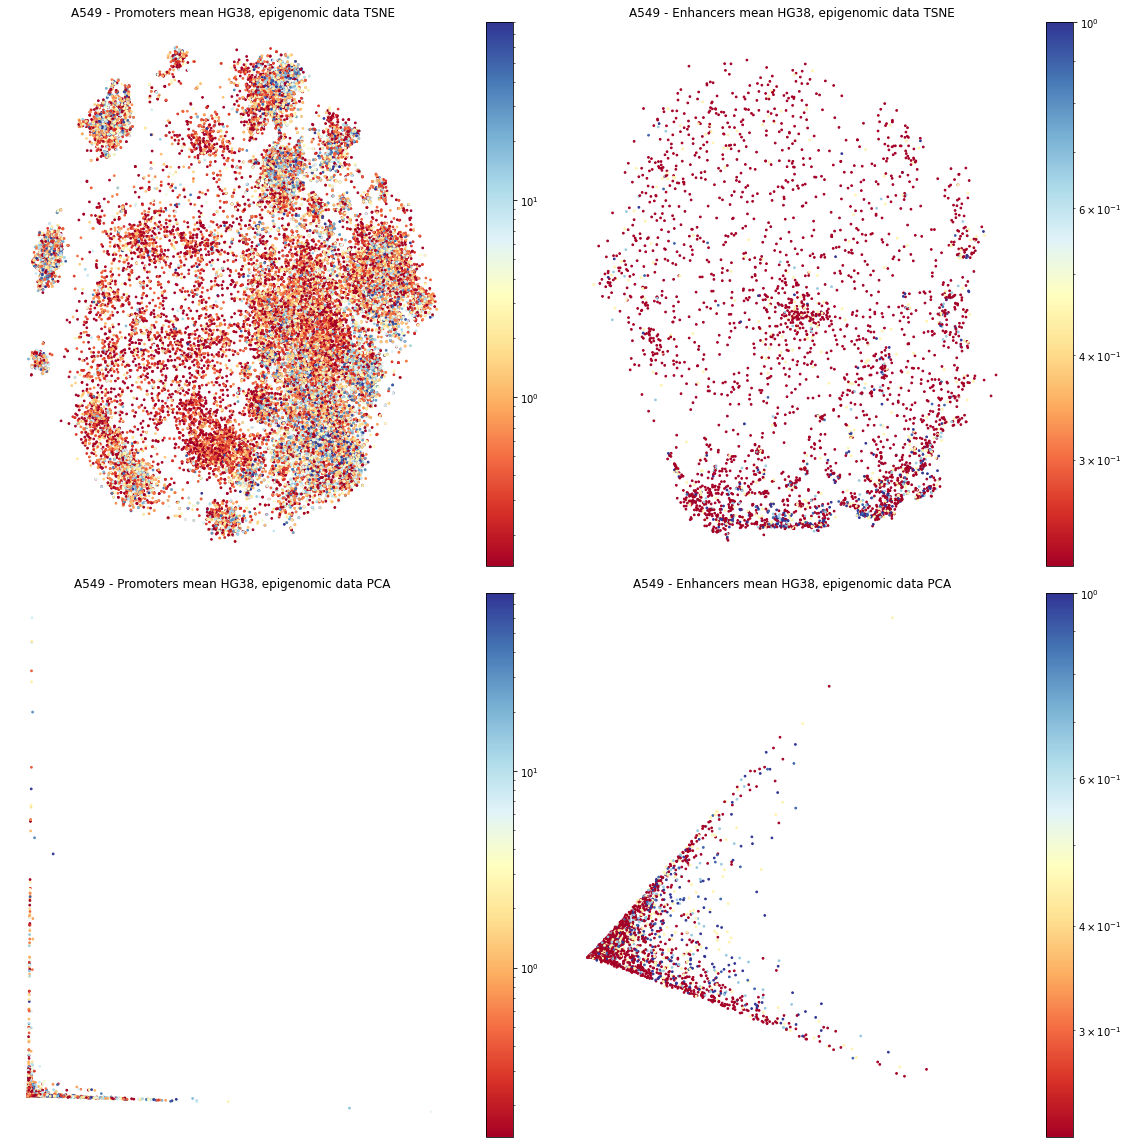

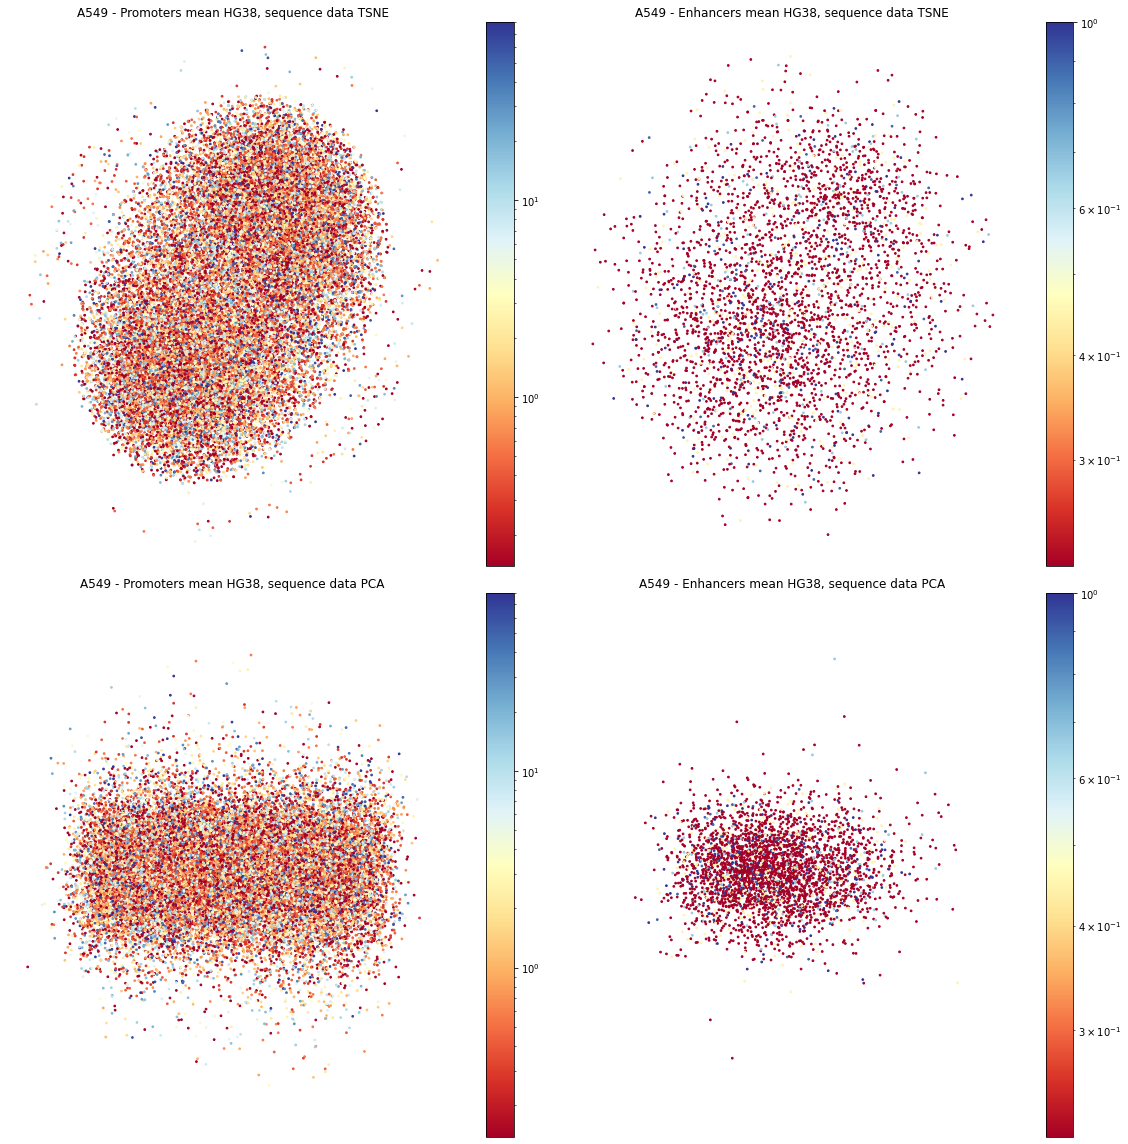

In [ ]:
epigenomic_fig, epigenomic_axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(16, 16),
    squeeze=False
)

sequence_fig, sequence_axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(16, 16),
    squeeze=False
)


for l, decomposition_method in enumerate(tqdm((get_tsne_decomposition, get_pca_decomposition), desc="Decomposition method", leave=False)):
    for j, ((epigenomic, scores), region) in enumerate(tqdm((
        ((epigenomes['promoters'], labels['promoters']), "Promoters"),
        ((epigenomes['enhancers'], labels['enhancers']), "Enhancers")
    ), desc="Task", leave=False)):
        
        decomposed_epigenomic = decomposition_method(
            epigenomic,
            "epigenomic",
            region,
            cell_line='A549',
            metric='cosine',
            perplexity=30
        )
        
        scatter_with_heatmap(
            decomposition=decomposed_epigenomic,
            scores=scores.values,
            figure=epigenomic_fig,
            ax=epigenomic_axes[l][j]
        )

        sequence = pd.DataFrame(
            np.array(BedSequence(
                genome,
                bed=to_bed(scores),
                batch_size=1
            )).reshape(-1, 4*256),
            index=scores.index
        )
        
        method = 'TSNE' if l == 0 else 'PCA'
        epigenomic_axes[l][j].set_title(f"{cell_line} - {region} mean HG38, epigenomic data {method}")
        epigenomic_axes[l][j].set_axis_off()

        decomposed_sequence = decomposition_method(
            sequence,
            "sequence",
            region,
            cell_line='A549',
            metric="cosine",
            perplexity=30
        )
        scatter_with_heatmap(
            decomposition=decomposed_sequence,
            scores=scores.values,
            figure=sequence_fig,
            ax=sequence_axes[l][j]
        )
        sequence_axes[l][j].set_title(f"{cell_line} - {region} mean HG38, sequence data {method}")
        sequence_axes[l][j].set_axis_off()

epigenomic_fig.tight_layout()
sequence_fig.tight_layout()
plt.show()

# Models learning
We will focus on a classification task because it's easier to evaluate the performances by exploiting the binarized labels we created.

### Creating sequences

In [130]:
def get_cnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    y: np.ndarray,
    batch_size: int = 256
) -> MixedSequence:
    """Returns sequence to train a CNN model on genomic sequences.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a CNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

def get_ffnn_sequence(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 32
) -> MixedSequence:
    """Returns sequence to train a FFNN model on epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a FFNN.
    """
    return MixedSequence(
        x={
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

def get_mmnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 256
) -> MixedSequence:
    """Returns sequence to train a MMNN model on both genomic sequences and epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a MMNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            ),
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

### Fixed Models

The architectures of the models are based on the paper: Boosting tissue-specic prediction of active cis-regulatory regions through deep learning and Bayesian optimization techniques.

In [131]:
def build_fixed_ffnn( input_shape: int )->Tuple[Model, Layer, Layer]:
    """Returns Feed-Forward Neural Network model for binary classification.
    
    Parameters
    -----------------------
    input_shape: int,
        Number of features in the input layer.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
    hidden = Dense( 16, activation="relu")(input_epigenomic_data)
    hidden = Dense( 4, activation="relu")(hidden)
    hidden = Dense( 2, activation="relu")(hidden)
    
    last_hidden_ffnn = hidden
    output_ffnn = Dense(1, activation="sigmoid")(input_epigenomic_data)

    ffnn = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="FFNN"
    )

    ffnn.compile(
        optimizer = SGD(learning_rate=0.5, decay=0.1),
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    return ffnn, input_epigenomic_data, last_hidden_ffnn

def build_fixed_cnn( window_size: int )->Tuple[Model, Layer, Layer]:

    """Returns Convolutional Neural Network model for binary classification.
    
    Parameters
    -----------------------
    window_size: int,
        Size of the input genomic window.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_sequence_data = Input(shape=(window_size, 4), name="sequence_data")
    hidden = Conv1D(64, kernel_size=5, activation="relu")(input_sequence_data)
    hidden = Conv1D(64, kernel_size=5, activation="relu")(hidden)
    hidden = Conv1D(64, kernel_size=5, activation="relu")(hidden)
    hidden = MaxPool1D(pool_size=2)(hidden)
    hidden = Conv1D( 128, kernel_size=3, activation="relu")(hidden)
    hidden = Conv1D( 128, kernel_size=3, activation="relu")(hidden)
    hidden = Conv1D( 128, kernel_size=3, activation="relu")(hidden)
    hidden = MaxPool1D(pool_size=2)(hidden)
    hidden = Conv1D( 128, kernel_size=3, activation="relu")(hidden)
    hidden = Conv1D( 128, kernel_size=3, activation="relu")(hidden)
    hidden = Conv1D( 128, kernel_size=3, activation="relu")(hidden)
    hidden = GlobalAveragePooling1D()(hidden)
    
    hidden = Dropout(rate=0.5)(hidden)
    hidden = Dense(10, activation="relu")(hidden)
    hidden = Dense(10, activation="relu")(hidden)
    last_hidden_cnn = Dropout(rate=0.5)(hidden)
    output_cnn = Dense(1, activation="sigmoid")(last_hidden_cnn)

    cnn = Model(
        inputs=input_sequence_data,
        outputs=output_cnn,
        name="CNN"
    )

    cnn.compile(
        optimizer = Nadam(lr = 0.002),
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    return cnn, input_sequence_data, last_hidden_cnn


def build_fixed_mmnn(
    input_shape: Optional[int] = None,
    window_size: Optional[int] = None,
    input_epigenomic_data: Optional[Layer] = None,
    input_sequence_data: Optional[Layer] = None,
    last_hidden_ffnn: Optional[Layer] = None,
    last_hidden_cnn: Optional[Layer] = None,
):
    """Returns Multi-Modal Neural Network model for binary classification.
    
    Implementative details
    -----------------------
    If the input shape / window size is not provided and the input layers and 
    the feature selection layers are provided, then the network will start
    to train from those layers (which are expected to be pre-trained).
    Conversely, it will create the submodules for the epigenomic and sequence
    data ex-novo.
    
    Parameters
    -----------------------
    input_shape: Optional[int] = None,
        Number of features in the input layer.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    window_size: int,
        Size of the input genomic window.
        Either the window size or the input and output layers of the CNN
        must be provided.
    input_epigenomic_data: Optional[Layer] = None,
        Input for the epigenomic data from a FFNN model.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    input_sequence_data: Optional[Layer] = None,
        Input for the sequence data from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
    last_hidden_ffnn: Optional[Layer] = None,
        Feature selection layer from a FFNN model.    
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    last_hidden_cnn: Optional[Layer] = None,
        Feature selection layer from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
        
    Raises
    -----------------------
    ValueError,
        If the input shape is not provided and the input layer and feature selection
        layer of the FFNN are not provided.
    ValueError,
        If the window size is not provided and the input layer and feature selection
        layer of the CNN are not provided.
        
    Returns
    -----------------------
    Triple with model, dummy output, dummy output."""
    
    if input_shape is None and (last_hidden_ffnn is None or input_epigenomic_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input epigenomic "
            "layer must be provided."
        )
    if window_size is None and (last_hidden_cnn is None or input_sequence_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input sequence "
            "layer must be provided."
        )
        
    if input_shape is not None:
        _, input_epigenomic_data, last_hidden_ffnn = build_fixed_ffnn(input_shape)
        
    if window_size is not None:
        _, input_sequence_data, last_hidden_cnn = build_fixed_cnn(window_size)
        
    concatenation_layer = Concatenate()([
        last_hidden_ffnn,
        last_hidden_cnn
    ])

    last_hidden_mmnn = Dense(64, activation="relu")(concatenation_layer)
    output_mmnn = Dense(1, activation="sigmoid")(last_hidden_mmnn)

    mmnn = Model(
        inputs=[input_epigenomic_data, input_sequence_data],
        outputs=output_mmnn,
        name="BoostedMMNN" if input_shape is None else "MMNN"
    )

    mmnn.compile(
        optimizer = Nadam(lr = 0.002),
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )

    return mmnn, None, None 


def build_fixed_rf():
    """
    Returns a RandomForestClassifier for binary classification.
    
    Returns
    -----------------------
    RandomForest model for binary classification.
    """
    return RandomForestClassifier(n_jobs=cpu_count(), class_weight='balanced_subsample', max_depth=5)

In [14]:
@Cache(
    cache_path=[
        "model_histories/{cell_line}/{task}/{model_name}/history_{_hash}.csv.xz",
        "model_performance/{cell_line}/{task}/{model_name}/performance_{_hash}.csv.xz",
    ],
    args_to_ignore=[
        "model", "training_sequence", "test_sequence"
    ]
)
def train_model(
    model: Model,
    model_name: str,
    task: str,
    cell_line: str,
    training_sequence: MixedSequence,
    test_sequence: MixedSequence,
    holdout_number: int,
    epochs: int,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Train the provided Neural Network and returns training history + model evaluations.
    
    Parameters
    ---------------------
    model: Model,
        The model to train.
    model_name: str,
        The model name.
    task: str,
        The name of the task.
    cell_line: str,
        Name of the considered cell line.
    training_sequence: MixedSequence,
        The training sequence.
    test_sequence: MixedSequence,
        The test sequence.
    holdout_number: int,
        The number of the current holdout.
    epochs: int,
        The max number of epochs to execute
        
    Returns
    ----------------------
    Tuple with training history dataframe and model evaluations dataframe.
    """
    history = pd.DataFrame(model.fit(
        train_sequence,
        validation_data=test_sequence,
        epochs=epochs,
        verbose=False,
        callbacks=[EarlyStopping(
            monitor="AUPRC",
            mode="max",
            min_delta=0.001,
            patience=5,
            restore_best_weights=True
        ),
        TqdmCallback(1)]
    ).history)
    
    train_evaluation = dict(zip(model.metrics_names, model.evaluate(train_sequence, verbose=False)))
    test_evaluation = dict(zip(model.metrics_names, model.evaluate(test_sequence, verbose=False)))
    train_evaluation["run_type"] = "train"
    test_evaluation["run_type"] = "test"
    
    for evaluation in (train_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["task"] = task
        evaluation["holdout_number"] = holdout_number
    
    evaluations = pd.DataFrame([
        train_evaluation,
        test_evaluation
    ])
    
    return history, evaluations

def train_rf(
    model: RandomForestClassifier,
    model_name: str,
    task: str,
    cell_line: str,
    train_X,
    train_y,
    test_X,
    test_y,
    holdout_number: int
):
    """Train the provided Random Forest and returns the performance evaluation dataframe.
    
    Parameters
    ---------------------
    model: RandomForestClassifier,
        The RandomForestClassifier object to train.
    model_name: str,
        The model name.
    task: str,
        The name of the task.
    train_X: numpy.ndarray,
        The Epigenomic training data.
    train_y: numpy.ndarray,
        The Epigenomic training labels.
    test_X: numpy.ndarray,
        The Epigenomic test data to evaluate the model on.
    test_y: numpy.ndarray,
        The Epigenomic test labels.
    holdout_number: int,
        The number of the current holdout.
        
    Returns
    ----------------------
    Tuple with best_model and model evaluations dataframe.
    """
    model.fit(train_X, train_y)
    predicted_y = model.predict(test_X)
    metrics_names = ['AUPRC', 'AUROC', 'f1_score']
    
    positive_proba = [x[1] for x in model.predict_proba(train_X)]
    training_metrics = [ metric(y_true = train_y, y_score = positive_proba) for metric in (average_precision_score, roc_auc_score )]
    training_metrics.append(f1_score(y_true = train_y, y_pred = model.predict(train_X)))
    
    positive_proba = [x[1] for x in model.predict_proba(test_X)]
    test_metrics = [ metric(y_true = test_y, y_score = positive_proba) for metric in ( average_precision_score, roc_auc_score )]
    test_metrics.append(f1_score(y_true = test_y, y_pred = model.predict(test_X)))
    
    train_evaluation = dict(zip(metrics_names, training_metrics ))
    test_evaluation = dict(zip(metrics_names, test_metrics))
    
    train_evaluation["run_type"] = "train"
    test_evaluation["run_type"] = "test"
    
    for evaluation in (train_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["task"] = task
        evaluation["holdout_number"] = holdout_number
    
    evaluations = pd.DataFrame([
        train_evaluation,
        test_evaluation
    ])
    
    return evaluations

*Monte Carlo Cross Validation*

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

number_of_splits = 10

holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2,
    random_state=42
)

In [16]:
# Create a list to store all the computed performance
all_fixed_performance = []

training_histories = {}

window_size = 256
cell_line = "A549"


for task, threshold, feature_selection in tqdm(( (active_promoters_vs_inactive_promoters, 1, False), 
                                                 (active_enhancers_vs_inactive_enhancers, 0, True), 
                                                 (active_enhancers_vs_inactive_enhancers, 0, False) ), desc="Tasks"):
    task_name = task.__name__+ (' (FS)' if feature_selection==True else ' (NO FS)')
    print(task_name)
    
    X, y = task(
        cell_line=cell_line,
        assembly = assembly,
        window_size=window_size,
        metric='mean'
    )

    #Labels binarization [enhancers threshold = 0.0; promoters threshold = 1.0]
    y = y > threshold

    # If feature_selection is active dropping not selected features
    if feature_selection:
        X = X.filter(items=enhancers_features, axis=1)

    training_histories[task_name] = []
    # Extract the bed coordinates from the epigenomic dataset
    bed = to_bed(X)
    # Get the number of features of this specific dataset
    number_of_features = X.shape[1]

    # Start the main loop, iterating through the holdouts
    for holdout_number, (train_indices, test_indices) in tqdm( enumerate(holdouts_generator.split(X, y)), total=number_of_splits, leave=False, desc="Computing holdouts"):
        print('-'*50)
        print(f'Holdout number: {holdout_number}; train_indices: {train_indices}; test_indices: {test_indices}')
        print('-'*50)
        
        # Get the training and test data
        train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
        train_X, test_X = X.iloc[train_indices], X.iloc[test_indices]
        train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]
        
        # Impute and normalize the epigenomic data
        train_X, test_X = normalize_epigenomic_data(train_X, test_X)
        
        # Flatten the output values
        train_y = train_y.values.flatten()
        test_y = test_y.values.flatten()
        
        # Training the Neural Networks
        for model, train_sequence, test_sequence, epochs  in tqdm( (
                                                                      (build_fixed_ffnn( input_shape = number_of_features), get_ffnn_sequence(train_X, train_y), get_ffnn_sequence(test_X, test_y) , 64 ),
                                                                      (build_fixed_cnn( window_size = window_size), get_cnn_sequence(genome, train_bed, train_y), get_cnn_sequence(genome, test_bed, test_y), 100),
                                                                      (build_fixed_mmnn( input_shape = number_of_features, window_size = window_size), get_mmnn_sequence(genome, train_bed, train_X, train_y), get_mmnn_sequence(genome, test_bed, test_X, test_y), 100)
                                                                 ) ):
            # We compute the model performance
            history, performance = train_model (
                model[0],
                model[0].name,
                task_name,
                cell_line,
                train_sequence,
                test_sequence,
                holdout_number,
                epochs = epochs
            )
            training_histories[task_name].append(history)
            all_fixed_performance.append(performance)
        
        # Training the Random Forest
        performance = train_rf ( 
            build_fixed_rf(),
            'RF',
            task_name,
            cell_line,
            train_X,
            train_y,
            test_X,
            test_y,
            holdout_number
        )
        all_fixed_performance.append(performance)
        
all_fixed_performance = pd.concat(all_fixed_performance)

Tasks:   0%|          | 0/3 [00:00<?, ?it/s]

active_promoters_vs_inactive_promoters (NO FS)


Computing holdouts:   0%|          | 0/10 [00:00<?, ?it/s]

--------------------------------------------------
Holdout number: 0; train_indices: [11275 51464 73977 ... 94478 49409 12510]; test_indices: [91779 87919 99423 ... 48695 77479 80871]
--------------------------------------------------
--------------------------------------------------
Holdout number: 1; train_indices: [46169 82430  5597 ... 51231 39117 77181]; test_indices: [83414 88303 48758 ... 50813 83245 40572]
--------------------------------------------------
--------------------------------------------------
Holdout number: 2; train_indices: [38429  4081 82246 ... 53828 82782 91284]; test_indices: [80163 57531 11703 ... 35174 57287 27180]
--------------------------------------------------
--------------------------------------------------
Holdout number: 3; train_indices: [47999 94271  5854 ... 95117 66096 88790]; test_indices: [16873 14535  7007 ... 78408 20327 84842]
--------------------------------------------------
--------------------------------------------------
Holdout n

Computing holdouts:   0%|          | 0/10 [00:00<?, ?it/s]

--------------------------------------------------
Holdout number: 0; train_indices: [34444 48296 19307 ... 48048    30 62333]; test_indices: [52460 53418 28830 ...  1074 60479 56088]
--------------------------------------------------
--------------------------------------------------
Holdout number: 1; train_indices: [ 3157 59887  2261 ... 29499 18397 28183]; test_indices: [ 3743 23132 33015 ... 44748 25065 58423]
--------------------------------------------------
--------------------------------------------------
Holdout number: 2; train_indices: [54974 36146 42022 ... 54628  2162 27694]; test_indices: [41159 62327 32775 ... 14799 62152 39267]
--------------------------------------------------
--------------------------------------------------
Holdout number: 3; train_indices: [57127  9606 30140 ... 38535 34871  6508]; test_indices: [15193 15191 50504 ...  5025 23923 20517]
--------------------------------------------------
--------------------------------------------------
Holdout n

Computing holdouts:   0%|          | 0/10 [00:00<?, ?it/s]

--------------------------------------------------
Holdout number: 0; train_indices: [34444 48296 19307 ... 48048    30 62333]; test_indices: [52460 53418 28830 ...  1074 60479 56088]
--------------------------------------------------
--------------------------------------------------
Holdout number: 1; train_indices: [ 3157 59887  2261 ... 29499 18397 28183]; test_indices: [ 3743 23132 33015 ... 44748 25065 58423]
--------------------------------------------------
--------------------------------------------------
Holdout number: 2; train_indices: [54974 36146 42022 ... 54628  2162 27694]; test_indices: [41159 62327 32775 ... 14799 62152 39267]
--------------------------------------------------
--------------------------------------------------
Holdout number: 3; train_indices: [57127  9606 30140 ... 38535 34871  6508]; test_indices: [15193 15191 50504 ...  5025 23923 20517]
--------------------------------------------------
--------------------------------------------------
Holdout n

In [5]:
with open('./dumped_files/all_fixed_performance.pkl', 'rb') as f:
    all_fixed_performance = pickle.load(file=f)

Rendering barplots:   0%|          | 0/3 [00:00<?, ?it/s]

((<Figure size 3000x660 with 3 Axes>,
  <Figure size 3000x660 with 3 Axes>,
  <Figure size 3000x660 with 3 Axes>),
 (array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002E6D17B5B20>,
        dtype=object),
  array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002E6D189E610>,
        dtype=object),
  array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002E6D1AD2CD0>,
        dtype=object)))

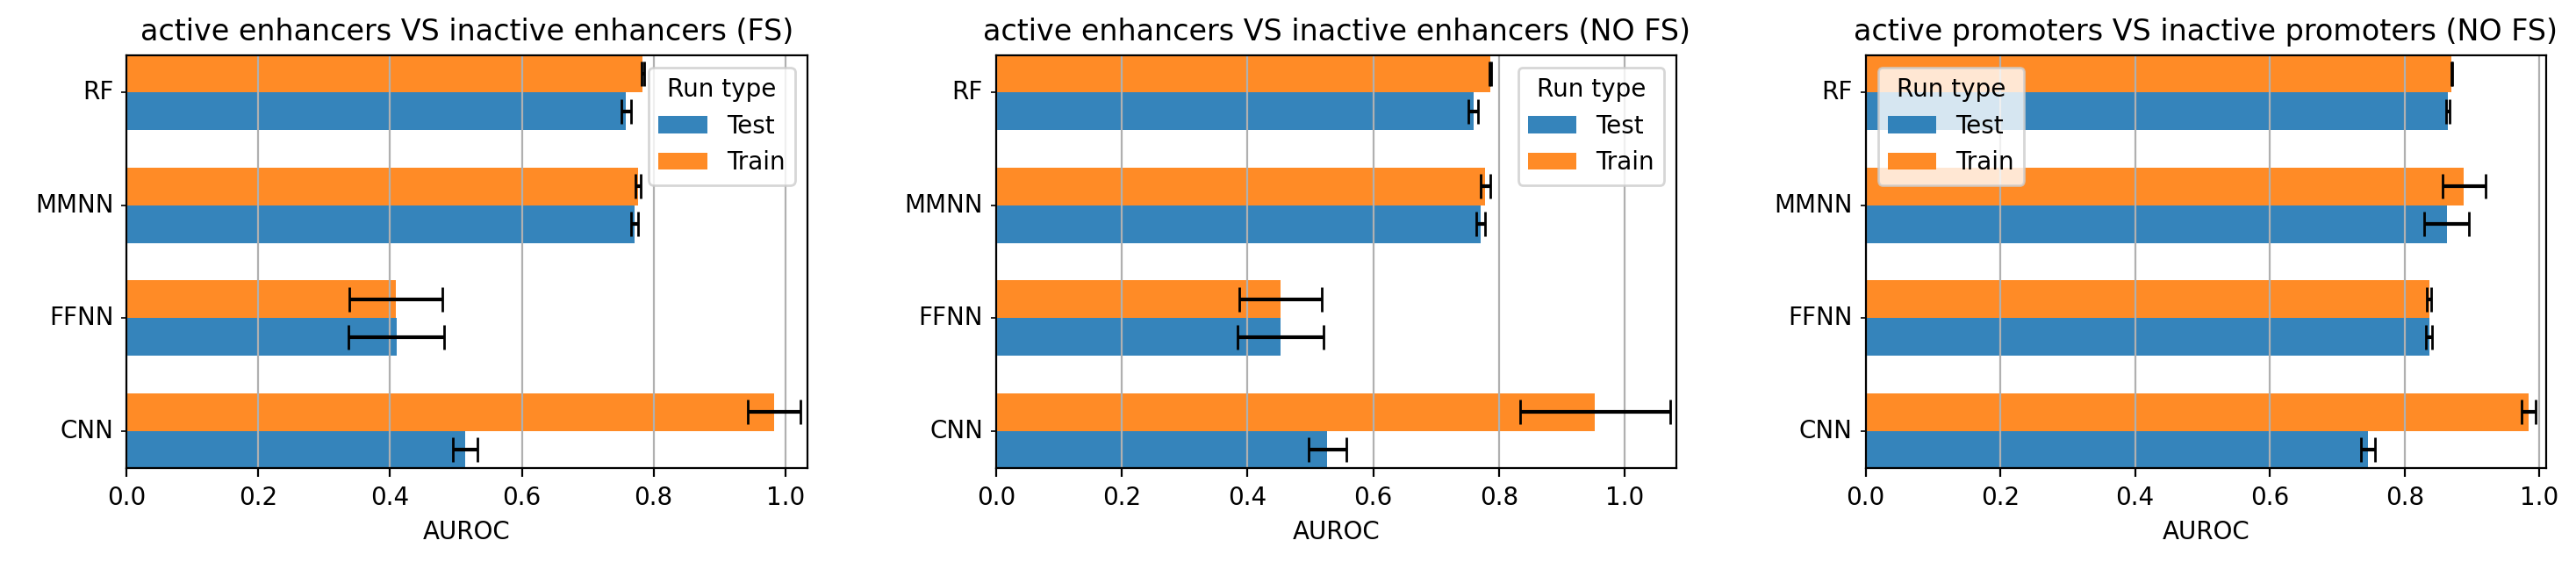

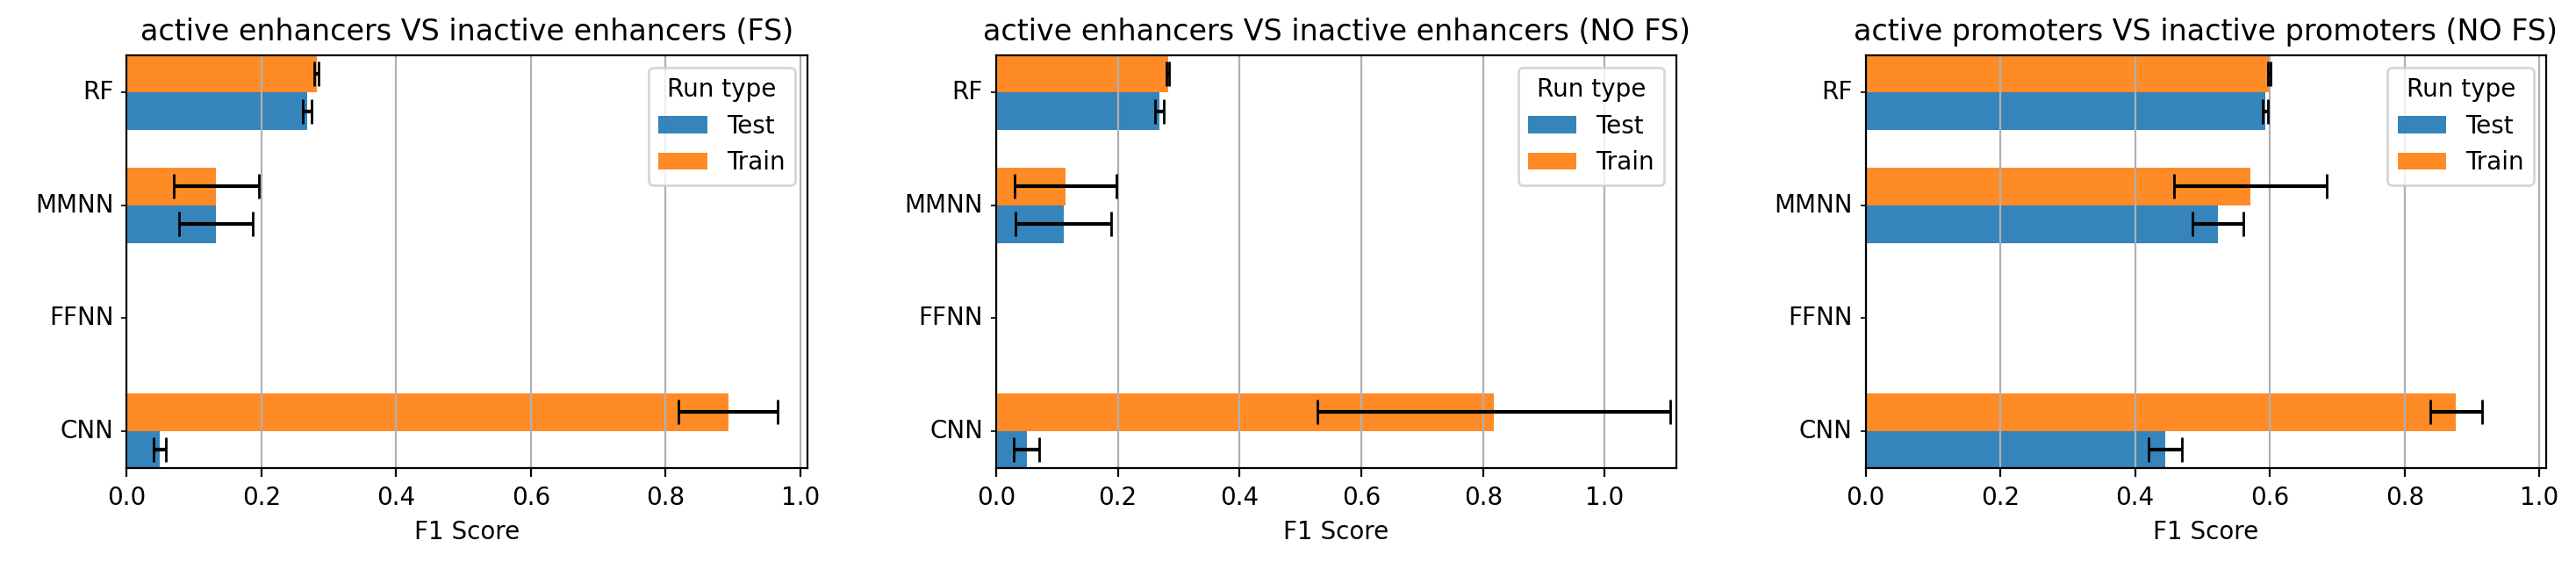

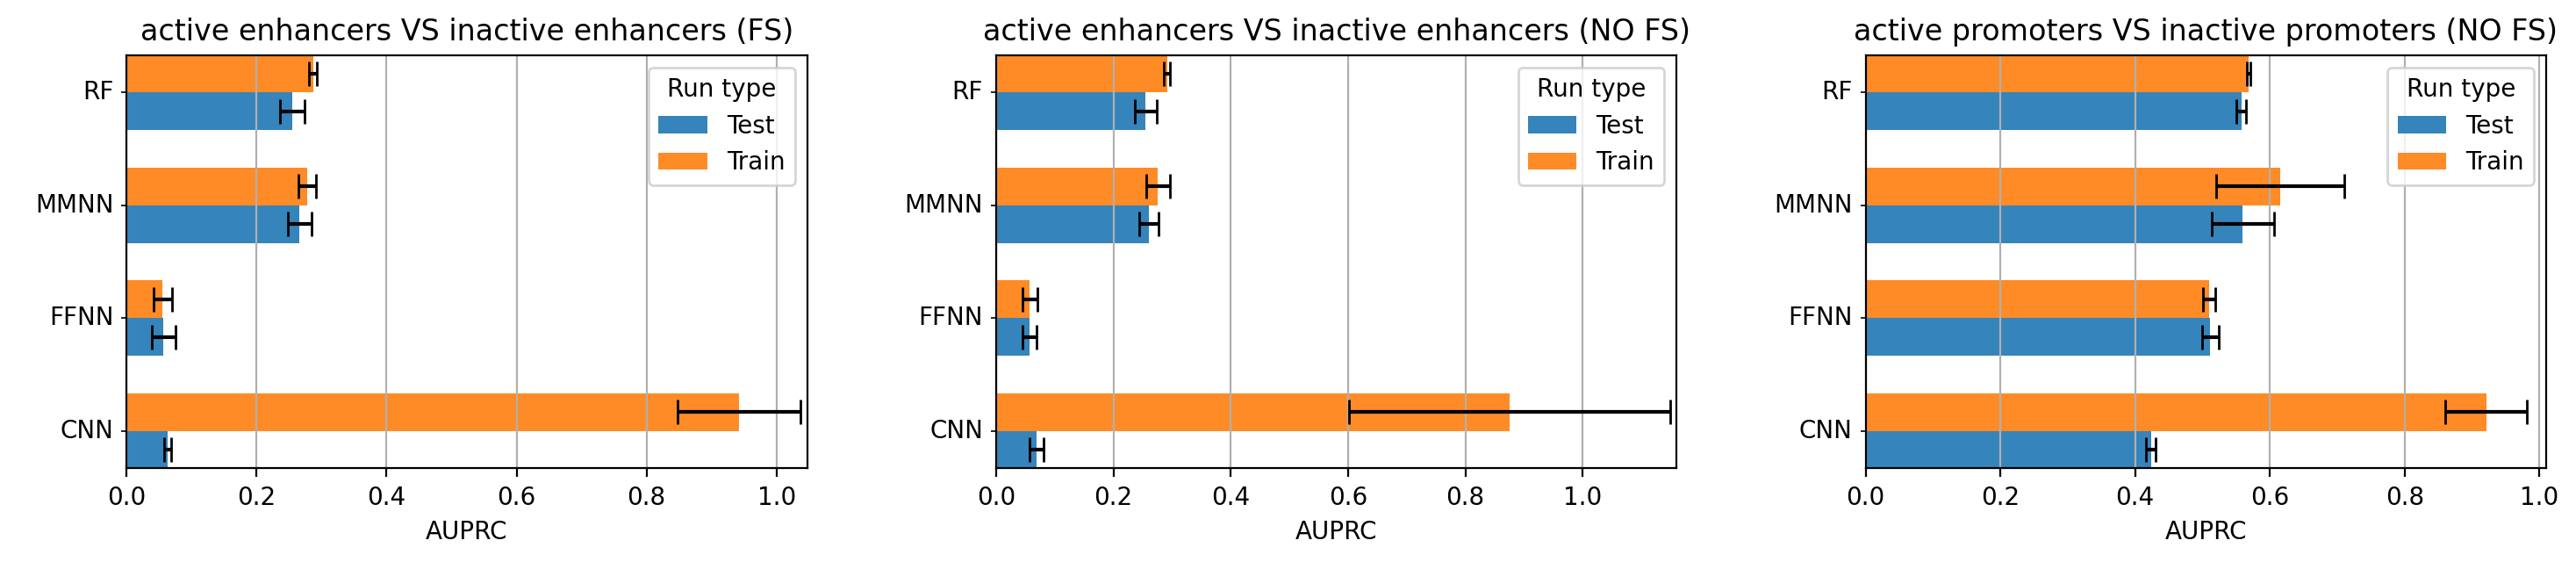

In [65]:
barplots(
    all_fixed_performance[[ 'AUPRC', 'AUROC','f1_score', "task", "model_name", "run_type"]],
    groupby=["task", "model_name", "run_type"],
    orientation="horizontal",
    height=5,
    subplots=True,
    major_rotation=90,
    use_multiprocessing=False
)

#### Statistical Tests on metrics distributions

In [66]:
test_performance_aeie_fs = all_fixed_performance[ (all_fixed_performance.run_type=='test') & (all_fixed_performance.task == 'active_enhancers_vs_inactive_enhancers (FS)')]
test_performance_aeie_nofs = all_fixed_performance[ (all_fixed_performance.run_type=='test') & (all_fixed_performance.task == 'active_enhancers_vs_inactive_enhancers (NO FS)')]
test_performance_apip_nofs = all_fixed_performance[ (all_fixed_performance.run_type=='test') & (all_fixed_performance.task == 'active_promoters_vs_inactive_promoters (NO FS)')]

*Test Fixed models on active_enhancers_vs_inactive_enhancers task (Feature Selection)*

In [67]:
ffnn_df = test_performance_aeie_fs[test_performance_aeie_fs.model_name=='FFNN']
mmnn_df = test_performance_aeie_fs[test_performance_aeie_fs.model_name=='MMNN']
cnn_df = test_performance_aeie_fs[test_performance_aeie_fs.model_name=='CNN']
rf_df = test_performance_aeie_fs[test_performance_aeie_fs.model_name=='RF']

for (name1, name2), (df1, df2) in zip([('FFNN', 'RF'), ('FFNN', 'CNN'), ('FFNN', 'MMNN'), ('RF', 'MMNN'), ('RF', 'CNN'), ('MMNN', 'CNN')], [(ffnn_df, rf_df), (ffnn_df, cnn_df), (ffnn_df, mmnn_df), (rf_df, mmnn_df), (rf_df, cnn_df), (mmnn_df, cnn_df)]):

    print(f" Wilcoxon test on {name1} f1_score ({np.mean(df1['f1_score'])}) and {name2} f1_score ({np.mean(df2['f1_score'])}): {wilcoxon( x = df1.f1_score, y = df2.f1_score)}") 
    print(f" Wilcoxon test on {name1} auprc ({np.mean(df1['AUPRC'])}) and {name2} auprc ({np.mean(df2['AUPRC'])}): {wilcoxon( x = df1.AUPRC, y = df2.AUPRC)}") 
    print(f" Wilcoxon test on {name1} auroc ({np.mean(df1['AUROC'])}) and {name2} auroc ({np.mean(df2['AUROC'])}): {wilcoxon( x = df1.AUROC, y = df2.AUROC)}") 
    print("\n")

 Wilcoxon test on FFNN f1_score (0.0) and RF f1_score (0.26825522605790314): WilcoxonResult(statistic=0.0, pvalue=0.001953125)
 Wilcoxon test on FFNN auprc (0.05659697018563743) and RF auprc (0.2550215622859302): WilcoxonResult(statistic=0.0, pvalue=0.001953125)
 Wilcoxon test on FFNN auroc (0.40940091013908386) and RF auroc (0.7584612384869094): WilcoxonResult(statistic=0.0, pvalue=0.001953125)


 Wilcoxon test on FFNN f1_score (0.0) and CNN f1_score (0.04895483739674086): WilcoxonResult(statistic=0.0, pvalue=0.001953125)
 Wilcoxon test on FFNN auprc (0.05659697018563743) and CNN auprc (0.06321552917361256): WilcoxonResult(statistic=13.0, pvalue=0.16015625)
 Wilcoxon test on FFNN auroc (0.40940091013908386) and CNN auroc (0.5135783821344375): WilcoxonResult(statistic=1.0, pvalue=0.00390625)


 Wilcoxon test on FFNN f1_score (0.0) and MMNN f1_score (0.13247457072138785): WilcoxonResult(statistic=0.0, pvalue=0.007685794055213263)
 Wilcoxon test on FFNN auprc (0.05659697018563743) and MM

*Test Fixed models on active_enhancers_vs_inactive_enhancers (No Feature Selection) task*

In [68]:
ffnn_df = test_performance_aeie_nofs[test_performance_aeie_nofs.model_name=='FFNN']
mmnn_df = test_performance_aeie_nofs[test_performance_aeie_nofs.model_name=='MMNN']
cnn_df = test_performance_aeie_nofs[test_performance_aeie_nofs.model_name=='CNN']
rf_df = test_performance_aeie_nofs[test_performance_aeie_nofs.model_name=='RF']

for (name1, name2), (df1, df2) in zip( [('FFNN', 'RF'), ('FFNN', 'CNN'), ('FFNN', 'MMNN'), 
                                        ('RF', 'MMNN'), ('RF', 'CNN'), ('MMNN', 'CNN')], 
                                       [(ffnn_df, rf_df), (ffnn_df, cnn_df), (ffnn_df, mmnn_df), 
                                        (rf_df, mmnn_df), (rf_df, cnn_df), (mmnn_df, cnn_df)]):

    print(f" Wilcoxon test on {name1} f1_score ({np.mean(df1['f1_score'])}) and {name2} f1_score ({np.mean(df2['f1_score'])}): {wilcoxon( x = df1.f1_score, y = df2.f1_score)}") 
    print(f" Wilcoxon test on {name1} auprc ({np.mean(df1['AUPRC'])}) and {name2} auprc ({np.mean(df2['AUPRC'])}): {wilcoxon( x = df1.AUPRC, y = df2.AUPRC)}") 
    print(f" Wilcoxon test on {name1} auroc ({np.mean(df1['AUROC'])}) and {name2} auroc ({np.mean(df2['AUROC'])}): {wilcoxon( x = df1.AUROC, y = df2.AUROC)}") 
    print("\n")

 Wilcoxon test on FFNN f1_score (0.0) and RF f1_score (0.2683641681578547): WilcoxonResult(statistic=0.0, pvalue=0.001953125)
 Wilcoxon test on FFNN auprc (0.05689952559769149) and RF auprc (0.25500165054631385): WilcoxonResult(statistic=0.0, pvalue=0.001953125)
 Wilcoxon test on FFNN auroc (0.4522928804159164) and RF auroc (0.7591430068083872): WilcoxonResult(statistic=0.0, pvalue=0.001953125)


 Wilcoxon test on FFNN f1_score (0.0) and CNN f1_score (0.049810519069433165): WilcoxonResult(statistic=0.0, pvalue=0.007685794055213263)
 Wilcoxon test on FFNN auprc (0.05689952559769149) and CNN auprc (0.0684646792709827): WilcoxonResult(statistic=11.0, pvalue=0.10546875)
 Wilcoxon test on FFNN auroc (0.4522928804159164) and CNN auroc (0.5267682403326035): WilcoxonResult(statistic=4.0, pvalue=0.013671875)


 Wilcoxon test on FFNN f1_score (0.0) and MMNN f1_score (0.11066846996545791): WilcoxonResult(statistic=0.0, pvalue=0.017960477526078766)
 Wilcoxon test on FFNN auprc (0.05689952559769149

*Test Fixed models on active_promoters_vs_inactive_promoters task*

In [69]:
ffnn_df = test_performance_apip_nofs[test_performance_apip_nofs.model_name=='FFNN']
mmnn_df = test_performance_apip_nofs[test_performance_apip_nofs.model_name=='MMNN']
cnn_df = test_performance_apip_nofs[test_performance_apip_nofs.model_name=='CNN']
rf_df = test_performance_apip_nofs[test_performance_apip_nofs.model_name=='RF']

for (name1, name2), (df1, df2) in zip([('FFNN', 'RF'), ('FFNN', 'CNN'), ('FFNN', 'MMNN'), 
                                       ('RF', 'MMNN'), ('RF', 'CNN'), ('MMNN', 'CNN')], 
                                      [(ffnn_df, rf_df), (ffnn_df, cnn_df), (ffnn_df, mmnn_df),
                                       (rf_df, mmnn_df), (rf_df, cnn_df), (mmnn_df, cnn_df)]):

    print(f" Wilcoxon test on {name1} f1_score ({np.mean(df1['f1_score'])}) and {name2} f1_score ({np.mean(df2['f1_score'])}): {wilcoxon( x = df1.f1_score, y = df2.f1_score)}") 
    print(f" Wilcoxon test on {name1} auprc ({np.mean(df1['AUPRC'])}) and {name2} auprc ({np.mean(df2['AUPRC'])}): {wilcoxon( x = df1.AUPRC, y = df2.AUPRC)}") 
    print(f" Wilcoxon test on {name1} auroc ({np.mean(df1['AUROC'])}) and {name2} auroc ({np.mean(df2['AUROC'])}): {wilcoxon( x = df1.AUROC, y = df2.AUROC)}") 
    print("\n")

 Wilcoxon test on FFNN f1_score (0.0) and RF f1_score (0.5931838580810032): WilcoxonResult(statistic=0.0, pvalue=0.001953125)
 Wilcoxon test on FFNN auprc (0.5115821182727813) and RF auprc (0.5574650802531347): WilcoxonResult(statistic=0.0, pvalue=0.001953125)
 Wilcoxon test on FFNN auroc (0.8362469375133514) and RF auroc (0.864581575312753): WilcoxonResult(statistic=0.0, pvalue=0.001953125)


 Wilcoxon test on FFNN f1_score (0.0) and CNN f1_score (0.44494723379611967): WilcoxonResult(statistic=0.0, pvalue=0.001953125)
 Wilcoxon test on FFNN auprc (0.5115821182727813) and CNN auprc (0.42358302474021914): WilcoxonResult(statistic=0.0, pvalue=0.001953125)
 Wilcoxon test on FFNN auroc (0.8362469375133514) and CNN auroc (0.7458216845989227): WilcoxonResult(statistic=0.0, pvalue=0.001953125)


 Wilcoxon test on FFNN f1_score (0.0) and MMNN f1_score (0.5228406578302384): WilcoxonResult(statistic=0.0, pvalue=0.001953125)
 Wilcoxon test on FFNN auprc (0.5115821182727813) and MMNN auprc (0.5598

### Hyper Models (Bayesian Optimization + GridSearch)

We realized 5 holdouts using Monte Carlo External Cross validation. Then each Model is trained on a sub set of the training set and optimized on a validation set. Of course in order to not depend on the specific training set we should resort on a Nested Cross Validation but we don't have enough resources to run it. Thus we opted on this approach in which we don't reach a global optimum but we have statistically realiable results.

In [139]:
class MetaFFNN(kt.HyperModel):

    def __init__(self, input_shape:int):
        self.input_shape = input_shape

    def build(self, hp: kt.HyperParameters)->Model:
        """Returns a Meta Feed-Forward Neural Network model for binary classification.
        
        Parameters
        -----------------------
        hp: kt.HyperParameters,
            Container for both a hyperparameter space, and current values.
            
        Returns
        -----------------------
        The MetaModel to search hyperparameters in.
        """
        input_epigenomic_data = x = Input(shape=(self.input_shape,), name="epigenomic_data")

        for i in range(hp.Int('num_layers', min_value = 1, max_value = 5, step=1)):
            x = Dense(
                units = hp.Int('units_' + str(i), min_value = 32, max_value = 128, default = 64), activation = 'relu')(x)
            x = Dropout(
                rate = hp.Float('drop_rate_' + str(i), min_value = 0.0, max_value = 0.9, step = 0.1, default = 0.2)
            )(x)

        output_ffnn = Dense(1, activation="sigmoid")(x)

        ffnn = Model(
            inputs=input_epigenomic_data,
            outputs=output_ffnn,
            name="MetaFFNN"
        )
        ffnn.compile(
            optimizer=Nadam(lr = hp.Float('lr', min_value = 1e-5, max_value = 1e-2, default = 1e-4)),
            loss="binary_crossentropy",
            metrics=get_complete_binary_metrics()
        )
        return ffnn

class MetaCNN(kt.HyperModel):

    def __init__(self, window_size:int):
        self.window_size = window_size

    def build(self, hp: kt.HyperParameters)->Model:
        """Returns a Meta Convolutional Neural Network model for binary classification.
        
        Parameters
        -----------------------
        hp: kt.HyperParameters,
            Container for both a hyperparameter space, and current values.
            
        Returns
        -----------------------
        The MetaModel to search hyperparameters in.
        """
        input_sequence_data = x = Input(shape=(window_size, 4), name="sequence_data")

        #Convolutional part
        for i in range(hp.Int('conv_layers', min_value = 1, max_value = 5, step=2)):
            x = Conv1D( filters = hp.Int('filters_' + str(i), min_value = 32, max_value = 128, default = 64), kernel_size = hp.Int('kernel_' + str(i), min_value = 3, max_value = 6, default=4), activation = 'relu')(x)
            x = Dropout(
                rate = hp.Float('conv_drop_rate_' + str(i), min_value = 0.3, max_value = 0.9, step = 0.1, default = 0.6)
            )(x)
            if hp.Choice("pooling_" + str(i), ["max", "avg"]) == "max":
                x = MaxPool1D(pool_size=2)(x)
            else:
                x = AveragePooling1D(pool_size=2)(x)

        if hp.Choice("global_pooling" + str(i), ["max", "avg"]) == "max":
            x = GlobalMaxPool1D()(x)
        else:
            x = GlobalAveragePooling1D()(x)
        
        #Dense part
        x = Dense(
            units = hp.Int('units', min_value = 16, max_value = 64, default = 16), activation = 'relu')(x)
        x = Dropout(
            rate = hp.Float('mlp_drop_rate' , min_value = 0.3, max_value = 0.9, step = 0.1, default = 0.6)
        )(x)

        output_cnn = Dense(1, activation="sigmoid")(x)

        cnn = Model(
            inputs=input_sequence_data,
            outputs=output_cnn,
            name="MetaCNN"
        )
        cnn.compile(
            optimizer=Nadam(lr = hp.Float('lr', min_value = 1e-5, max_value = 1e-2, default = 1e-4)),
            loss="binary_crossentropy",
            metrics=get_complete_binary_metrics()
        )
        return cnn

class MetaMMNN(kt.HyperModel):

    def __init__(self, window_size:int, input_shape:int):
        self.window_size = window_size
        self.input_shape = input_shape

    def build(self, hp: kt.HyperParameters)->Model:
        """Returns a Meta Multi Modal Neural Network model for binary classification.
        
        Parameters
        -----------------------
        hp: kt.HyperParameters,
            Container for both a hyperparameter space, and current values.
            
        Returns
        -----------------------
        The MetaModel to search hyperparameters in."""

        # Convolutional Network Branch

        input_sequence_data = cnn_x = Input(shape=(window_size, 4), name="sequence_data")

        #Convolutional part
        for i in range(hp.Int('conv_layers', min_value = 1, max_value = 5, step=2)):
            cnn_x = Conv1D( filters = hp.Int('filters_' + str(i), min_value = 32, max_value = 128, default = 64), kernel_size = hp.Int('kernel_' + str(i), min_value = 3, max_value = 6, default=4), activation = 'relu')(cnn_x)
            cnn_x = Dropout(
                rate = hp.Float('conv_drop_rate_' + str(i), min_value = 0.3, max_value = 0.9, step = 0.1, default = 0.6)
            )(cnn_x)
            if hp.Choice("pooling_" + str(i), ["max", "avg"]) == "max":
                cnn_x = MaxPool1D(pool_size=2)(cnn_x)
            else:
                cnn_x = AveragePooling1D(pool_size=2)(cnn_x)

        if hp.Choice("global_pooling" + str(i), ["max", "avg"]) == "max":
              cnn_x = GlobalMaxPool1D()(cnn_x)
        else:
            cnn_x = GlobalAveragePooling1D()(cnn_x)
        cnn_x = Dense(
            units = hp.Int('units', min_value = 16, max_value = 64, default = 16), activation = 'relu')(cnn_x)
        cnn_x = Dropout(
            rate = hp.Float('mlp_drop_rate' , min_value = 0.3, max_value = 0.9, step = 0.1, default = 0.6)
        )(cnn_x)

        # Feed Forward Neural Network Branch
        input_epigenomic_data = ffnn_x = Input(shape=(self.input_shape,), name="epigenomic_data")
        for i in range(hp.Int('num_layers', min_value = 1, max_value = 5, step=1)):
            ffnn_x = Dense(
                units = hp.Int('units_' + str(i), min_value = 32, max_value = 128, default = 64), activation = 'relu')(ffnn_x)
            ffnn_x = Dropout(
                rate = hp.Float('drop_rate_' + str(i), min_value = 0.3, max_value = 0.9, step = 0.1, default = 0.6)
            )(ffnn_x)
        
        #Concatenation Layer
        concatenation_layer = Concatenate()([
            ffnn_x,
            cnn_x
        ])
        
        last_hidden_mmnn = Dense( hp.Int('mmnn_units' + str(i), min_value = 16, max_value = 128, default = 64), activation="relu")(concatenation_layer)
        output_mmnn = Dense(1, activation="sigmoid")(last_hidden_mmnn)

        mmnn = Model(
            inputs=[input_epigenomic_data, input_sequence_data],
            outputs=output_mmnn,
            name="MetaMMNN"
        )

        mmnn.compile(
            optimizer = Nadam(lr = hp.Float('lr', min_value = 1e-5, max_value = 1e-2, default = 1e-4)),
            loss="binary_crossentropy",
            metrics=get_complete_binary_metrics()
        )

        return mmnn

In [28]:
def tune_model(
    meta_model: kt.HyperModel,
    model_name: str,
    task: str,
    training_sequence: MixedSequence,
    val_sequence: MixedSequence,
    test_sequence: MixedSequence,
    holdout_number: int
):
    """Tune the provided MetaModel and returns the best_model found, a results_summary and performance evaluations.
    
    Parameters
    ---------------------
    meta_model: kt.HyperModel,
        The metamodel to search parameter in.
    model_name: str,
        The meta model name.
    task: str,
        The name of the task.
    cell_line: str,
        Name of the considered cell line.
    training_sequence: MixedSequence,
        The training sequence.
    val_sequence: MixedSequence,
        The validation sequence to optimize parameters on.
    test_sequence: MixedSequence,
        The test sequence to evaluate the best model on.
    holdout_number: int,
        The number of the current holdout.
        
    Returns
    ----------------------
    Tuple with best_model, result_summary dataframe and model evaluations dataframe.
    """
    OBJECTIVE = kt.Objective('val_f1_score', direction = 'max')
    MAX_TRIALS = 50
    EXECUTIONS_PER_TRIAL = 1
    hp = kt.HyperParameters()

    callbacks = [EarlyStopping( 
                     monitor = 'f1_score',
                     min_delta = 0.001,
                     patience = 3,
                     mode = 'max',
                     restore_best_weights = True
                 )]
    
    tuner = kt.BayesianOptimization(
          hypermodel = meta_model,
          objective = OBJECTIVE,
          hyperparameters = hp,
          tune_new_entries = True,
          max_trials = MAX_TRIALS,
          executions_per_trial = EXECUTIONS_PER_TRIAL,
          seed = 42,
          directory = 'tuning/',
          project_name = model_name+task+'_holdout'+str(holdout_number)
    )

    tuner.search(
      training_sequence,
      validation_data=val_sequence,
      epochs = 1000,
      callbacks = callbacks,
      verbose = 1
    )
    
    #Creating evalutation dataframe
    best_model = tuner.get_best_models()[0]
    #Explicitly access to get_complete_binary_metrics methods names because keras_tuner object doesn't keep metrics names
    metrics_names = [type(x).__name__ for x in get_complete_binary_metrics()] 
    metrics_names[3] = 'AUROC'
    metrics_names[4] = 'AUPRC'
    
    train_evaluation = dict(zip(metrics_names, best_model.evaluate(training_sequence, verbose=False)))
    val_evaluation = dict(zip(metrics_names, best_model.evaluate(val_sequence, verbose=False)))
    test_evaluation = dict(zip(metrics_names, best_model.evaluate(test_sequence, verbose=False)))
    train_evaluation["run_type"] = "train"
    val_evaluation["run_type"] = "val"
    test_evaluation["run_type"] = "test"
    
    for evaluation in (train_evaluation, val_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["task"] = task
        evaluation["holdout_number"] = holdout_number
    
    evaluations = pd.DataFrame([
        train_evaluation,
        val_evaluation,
        test_evaluation
    ])
    
    results_summary = pd.DataFrame(tuner.results_summary())
    
    return best_model, results_summary, evaluations
   
    
def tune_rf(
    model_name: str,
    task: str,
    train_X: np.ndarray,
    train_y: np.ndarray,
    val_X: np.ndarray,
    val_y: np.ndarray,
    test_X: np.ndarray,
    test_y: np.ndarray,
    holdout_number: int
):
    """Creates a meta Random Forest and tune it. Then returns the best_model found and performance evaluations.
    
    Parameters
    ---------------------
    model_name: str,
        The meta model name.
    task: str,
        The name of the task.
    train_X: numpy.ndarray,
        The Epigenomic training data.
    train_y: numpy.ndarray,
        The Epigenomic training labels.
    val_X: numpy.ndarray,
        The Epigenomic validation data to optimize parameters on.
    val_y: numpy.ndarray,
        The Epigenomic validation labels.
    test_X: numpy.ndarray,
        The Epigenomic test data to evaluate the best model on.
    test_y: numpy.ndarray,
        The Epigenomic test labels.
    holdout_number: int,
        The number of the current holdout.
        
    Returns
    ----------------------
    Tuple with best_model and model evaluations dataframe.
    """
    # Defining search space
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [2, 5, 10]
    }
    # Performing GridSearch on the defined validation set of current iteration
    gs = GridSearch( 
             model = RandomForestClassifier( n_jobs=cpu_count(), 
             class_weight='balanced_subsample'), 
             param_grid = param_grid, 
             parallelize=False
    )
    gs.fit(
        X_train= train_X, 
        y_train=train_y, 
        X_val=val_X, 
        y_val=val_y
    )
    
    # Best Model Evaluation
    model = gs.best_estimator_
    metrics_names = ['AUPRC', 'AUROC', 'F1Score']
    
    # Computing performances for train,val and test sets 
    metrics = {'training': [], 'val': [], 'test': []}
    for metric_type, X, y in (('training', train_X, train_y), ('val', val_X, val_y), ('test', test_X, test_y)):
        
        positive_proba = [x[1] for x in model.predict_proba(X)]
        metrics [ metric_type ] = [ metric(y_true = y, y_score = positive_proba) for metric in (average_precision_score, roc_auc_score )]
        metrics [ metric_type ].append(f1_score(y_true = y, y_pred = model.predict(X)))

    train_evaluation = dict(zip(metrics_names, metrics['training'] ))
    val_evaluation = dict(zip(metrics_names, metrics['val'] ))
    test_evaluation = dict(zip(metrics_names, metrics['test']))
    
    train_evaluation["run_type"] = "train"
    val_evaluation["run_type"] = "val"
    test_evaluation["run_type"] = "test"
    
    for evaluation in (train_evaluation, val_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["task"] = task
        evaluation["holdout_number"] = holdout_number
    
    evaluations = pd.DataFrame([
        train_evaluation,
        val_evaluation,
        test_evaluation
    ])
    
    return model, evaluations

*Monte Carlo External Cross validation*

In [29]:
from sklearn.model_selection import StratifiedShuffleSplit

number_of_splits = 5

holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.35,
    random_state=42
)
#Holdout for tuning
val_test_generator = StratifiedShuffleSplit(n_splits=1, test_size=0.55, random_state=42)

In [30]:
window_size = 256
cell_line = "A549"

best_models = {'active_enhancers_vs_inactive_enhancers (FS)':[], 'active_promoters_vs_inactive_promoters (NO FS)': [], 'active_enhancers_vs_inactive_enhancers (NO FS)':[]}
results_summary = {'active_enhancers_vs_inactive_enhancers (FS)':[], 'active_promoters_vs_inactive_promoters (NO FS)': [], 'active_enhancers_vs_inactive_enhancers (NO FS)':[]}
all_tuning_performances = []

for task, threshold, feature_selection in tqdm(( (active_promoters_vs_inactive_promoters, 1, False), 
                                                 (active_enhancers_vs_inactive_enhancers, 0, True), 
                                                 (active_enhancers_vs_inactive_enhancers, 0, False) 
                                               ), desc="Tasks"):
    task_name = task.__name__+ (' (FS)' if feature_selection==True else ' (NO FS)')
    print(task_name)

    X, y = task(
        cell_line=cell_line,
        assembly = assembly,
        window_size=window_size,
        metric='mean'
    )

    #Labels binarization [enhancers threshold = 0.0; promoters threshold = 1.0]
    y = y > threshold

    #If feature_selection is active dropping not selected features
    if feature_selection:
        X = X.filter(items=enhancers_features, axis=1)

    # Extract the bed coordinates from the epigenomic dataset
    bed = to_bed(X)
    # Get the number of features of this specific dataset
    number_of_features = X.shape[1]

    for holdout_number, (train_indices, val_test_indices) in enumerate(holdouts_generator.split(X, y)):

        # Get the training and test data
        train_X, val_test_X = X.iloc[train_indices], X.iloc[val_test_indices]
        train_y, val_test_y = y.iloc[train_indices], y.iloc[val_test_indices]
        train_bed, val_test_bed = bed.iloc[train_indices], bed.iloc[val_test_indices]
        # Impute and normalize the epigenomic data (in order to avoid any leak the val_test set is normalized using the training set median and std)
        train_X, val_test_X = normalize_epigenomic_data(train_X, val_test_X)

        #Creating the validation set for hyperparameters tuning
        val_indices, test_indices = next(val_test_generator.split(val_test_X, val_test_y))
        val_X, test_X, val_y, test_y  = val_test_X[val_indices], val_test_X[test_indices], val_test_y.iloc[val_indices], val_test_y.iloc[test_indices]
        val_bed, test_bed = val_test_bed.iloc[val_indices], val_test_bed.iloc[test_indices]

        # Flatten the output values
        train_y = train_y.values.flatten()
        val_y = val_y.values.flatten()
        test_y = test_y.values.flatten()
        

        #Tuning the Neural Networks
        for meta_model, train_seq, val_seq, test_seq  in tqdm( (  
                                                                 (MetaCNN( window_size = window_size), get_cnn_sequence(genome, train_bed, train_y), get_cnn_sequence(genome, val_bed, val_y), get_cnn_sequence(genome, test_bed, test_y)),
                                                                 (MetaFFNN(input_shape = number_of_features), get_ffnn_sequence(train_X, train_y), get_ffnn_sequence(val_X, val_y) , get_ffnn_sequence(test_X, test_y) ),
                                                                 (MetaMMNN( window_size = window_size, input_shape = number_of_features), get_mmnn_sequence(genome, train_bed, train_X, train_y), get_mmnn_sequence(genome, val_bed, val_X, val_y), get_mmnn_sequence(genome, test_bed, test_X, test_y))
                                                              ) ):
            
            best_model, result_summary, evaluations = tune_model( 
                                                          meta_model = meta_model,
                                                          model_name = type(meta_model).__name__,
                                                          task = task_name,
                                                          training_sequence = train_seq,
                                                          val_sequence = val_seq,
                                                          test_sequence = test_seq,
                                                          holdout_number = holdout_number
                                                       )
            results_summary[task_name].append(result_summary)
            best_models[task_name].append(best_model)
            all_tuning_performances.append(evaluations)
        
        #Tuning the RandomForest
        best_model, evaluations = tune_rf( 
                                      'MetaRF',
                                      task_name,
                                      train_X,
                                      train_y,
                                      val_X,
                                      val_y,
                                      test_X,
                                      test_y,
                                      holdout_number
                                  )

        best_models[task_name].append(best_model)
        all_tuning_performances.append(evaluations)
            
all_tuning_performances = pd.concat(all_tuning_performances)

Tasks:   0%|          | 0/3 [00:00<?, ?it/s]

active_promoters_vs_inactive_promoters (NO FS)
active_enhancers_vs_inactive_enhancers (FS)
active_enhancers_vs_inactive_enhancers (NO FS)


In [7]:
with open('./dumped_files/all_tuning_performances.pkl', 'rb') as f:
    all_tuning_performances = pickle.load(file=f)

Rendering barplots:   0%|          | 0/3 [00:00<?, ?it/s]

((<Figure size 3300x900 with 3 Axes>,
  <Figure size 3300x900 with 3 Axes>,
  <Figure size 3300x900 with 3 Axes>),
 (array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002E6C6F5A850>,
        dtype=object),
  array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002E6C8280D00>,
        dtype=object),
  array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002E6C6C6EE50>,
        dtype=object)))

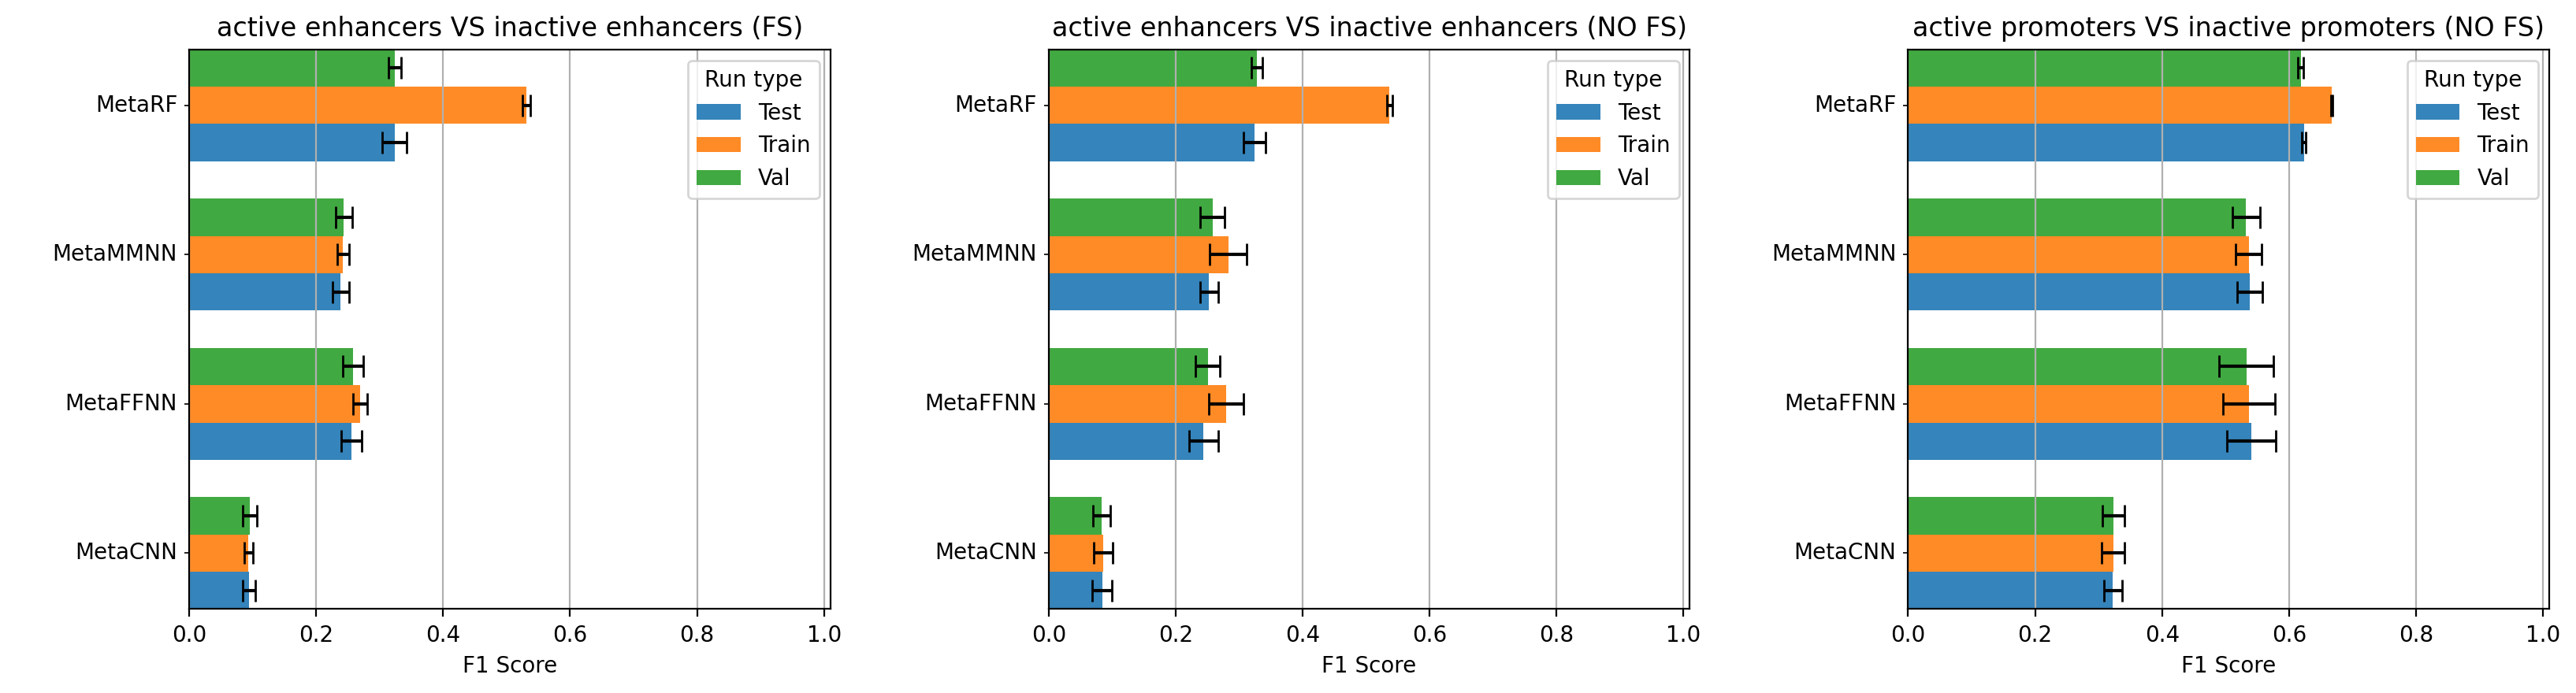

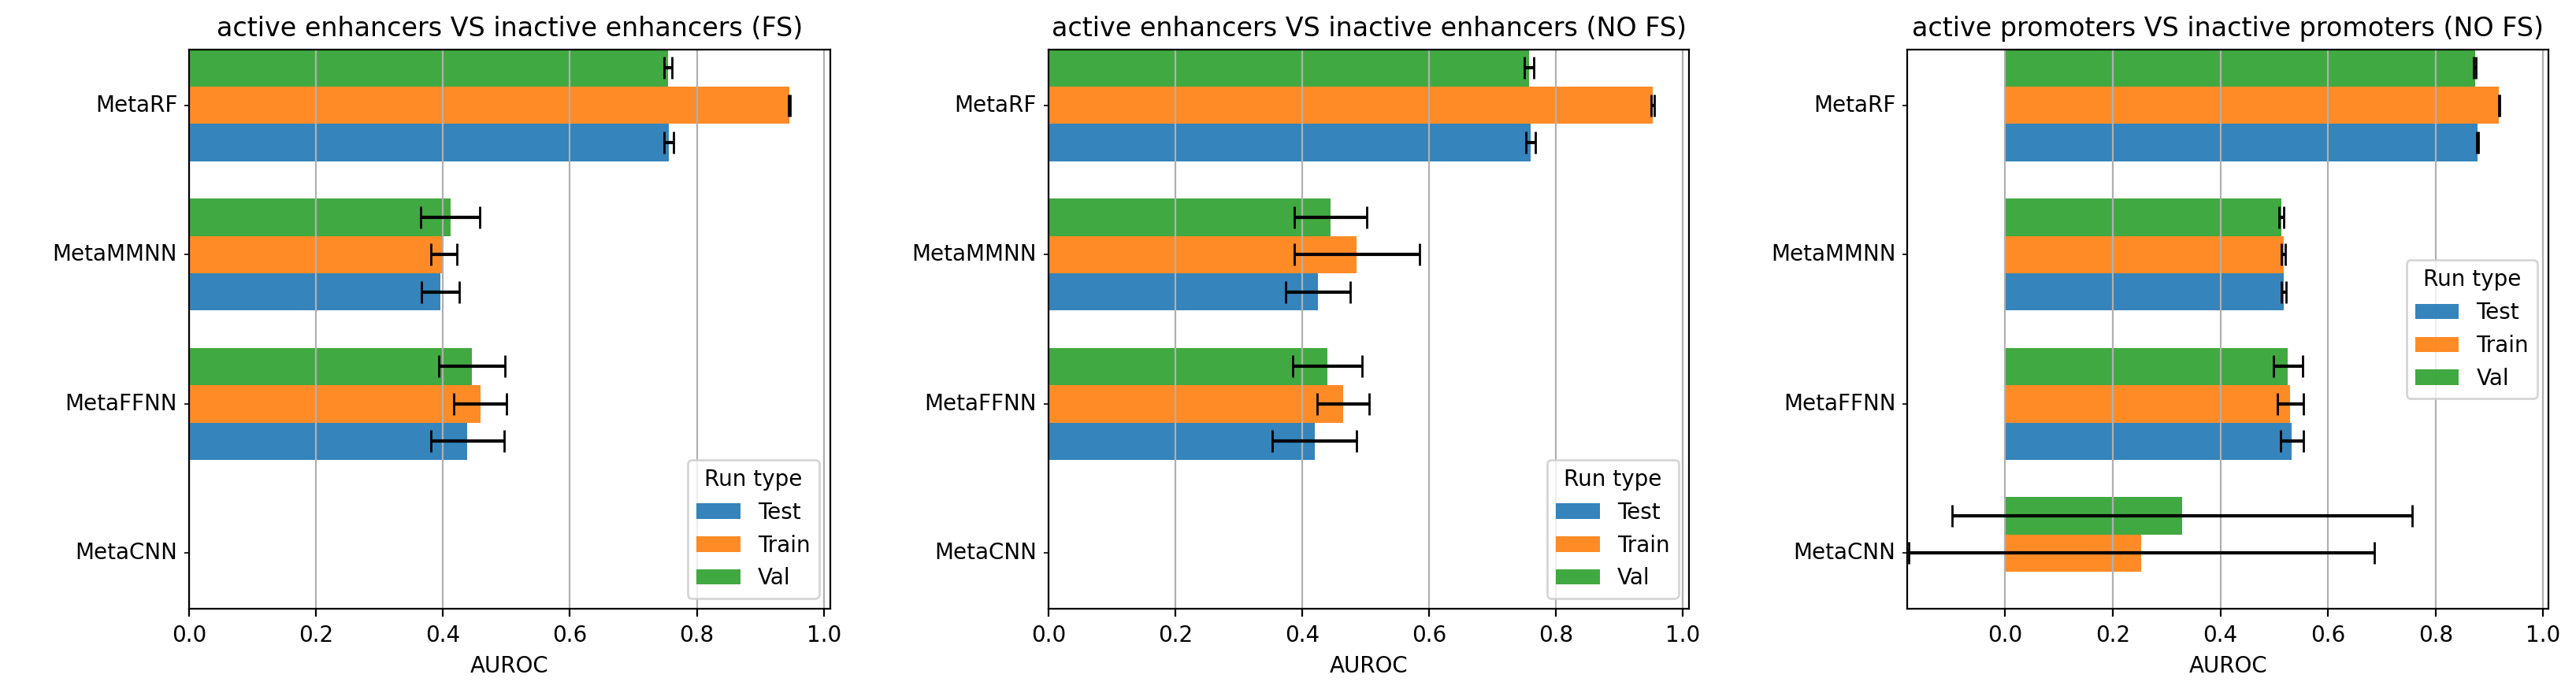

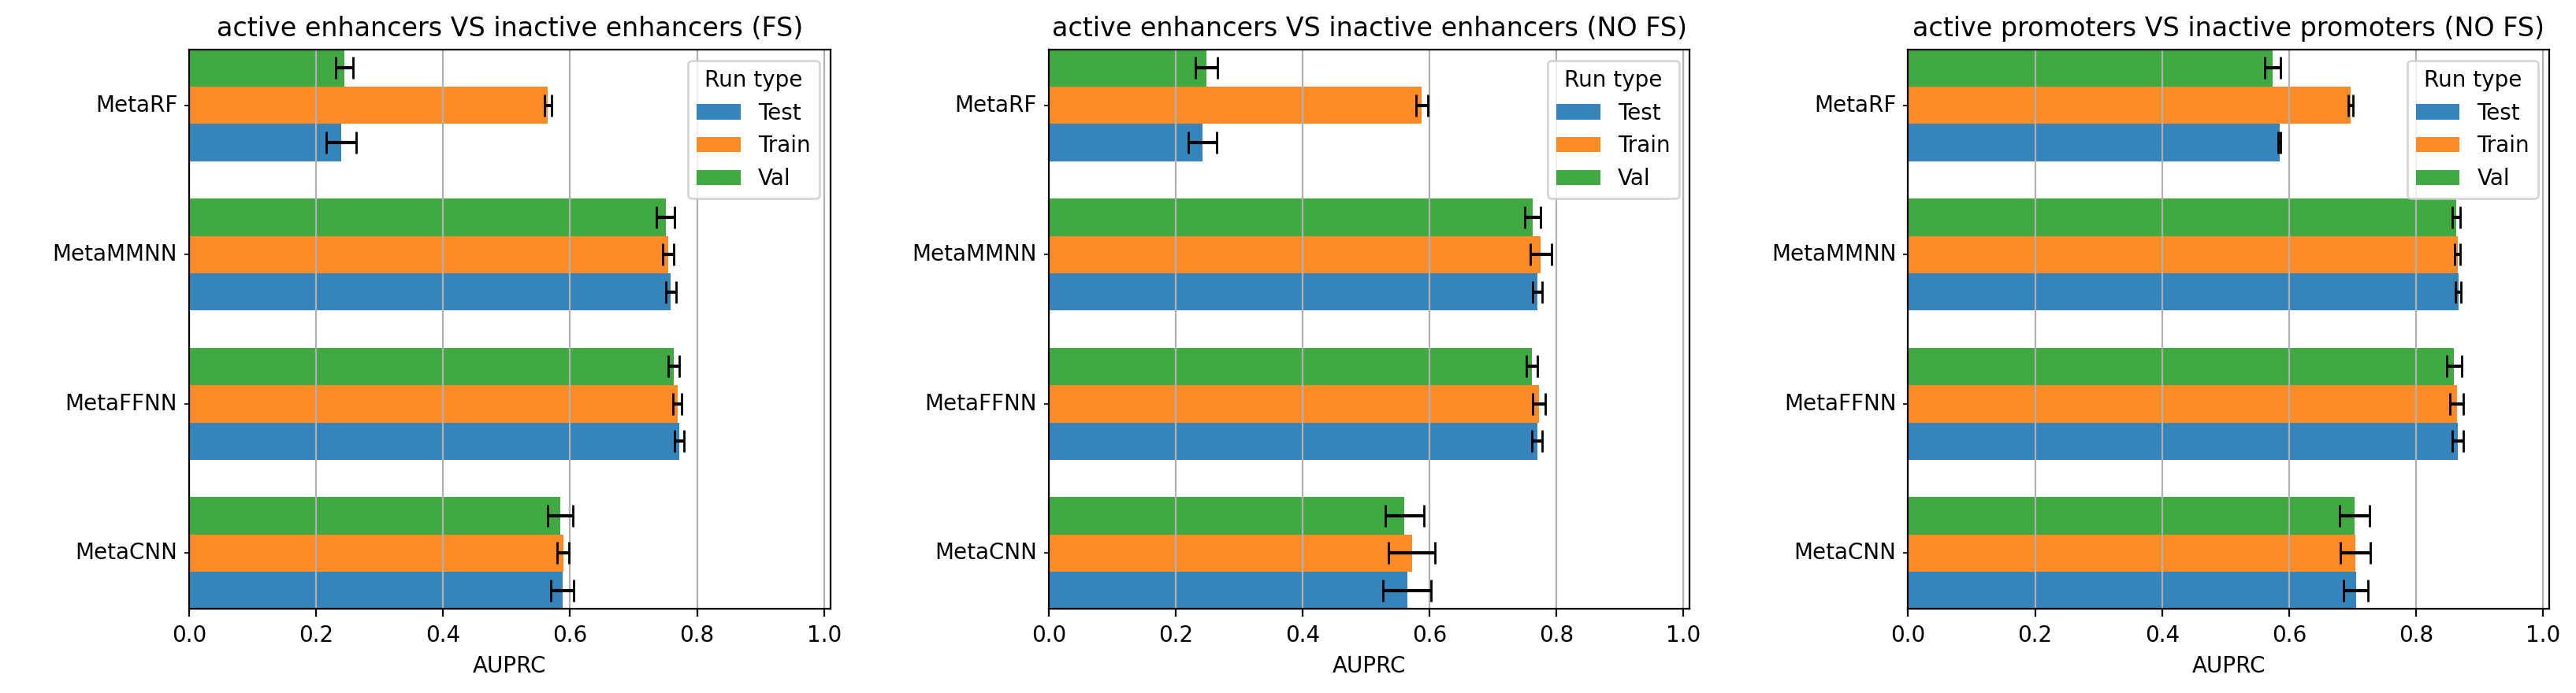

In [64]:
barplots(
    all_tuning_performances[[ 'AUROC', 'AUPRC','F1Score', 'task','model_name','run_type']],
    groupby=["task", "model_name", "run_type"],
    orientation="horizontal",
    height=5.5,
    subplots=True,
    major_rotation=90,
    use_multiprocessing=False
)

#### Statistical Tests on metrics distributions

In [43]:
tuning_test_performance_aeie_fs = all_tuning_performances[ (all_tuning_performances.run_type=='test') & (all_tuning_performances.task == 'active_enhancers_vs_inactive_enhancers (FS)')]
tuning_test_performance_aeie_nofs = all_tuning_performances[ (all_tuning_performances.run_type=='test') & (all_tuning_performances.task == 'active_enhancers_vs_inactive_enhancers (NO FS)')]
tuning_test_performance_apip_nofs = all_tuning_performances[ (all_tuning_performances.run_type=='test') & (all_tuning_performances.task == 'active_promoters_vs_inactive_promoters (NO FS)')]

*Test Meta models on active_enhancers_vs_inactive_enhancers (Feature Selection) task*

In [78]:
ffnn_df = tuning_test_performance_aeie_fs[tuning_test_performance_aeie_fs.model_name=='MetaFFNN']
mmnn_df = tuning_test_performance_aeie_fs[tuning_test_performance_aeie_fs.model_name=='MetaMMNN']
cnn_df = tuning_test_performance_aeie_fs[tuning_test_performance_aeie_fs.model_name=='MetaCNN']
rf_df = tuning_test_performance_aeie_fs[tuning_test_performance_aeie_fs.model_name=='MetaRF']

for (name1, name2), (df1, df2) in zip( [('META_FFNN', 'META_RF'), ('META_FFNN', 'META_CNN'), ('META_FFNN', 'META_MMNN'), 
                                        ('META_RF', 'META_MMNN'), ('META_RF', 'META_CNN'), ('META_MMNN', 'META_CNN')], 
                                       [(ffnn_df, rf_df), (ffnn_df, cnn_df), (ffnn_df, mmnn_df), 
                                        (rf_df, mmnn_df), (rf_df, cnn_df), (mmnn_df, cnn_df)]):

    print(f" Wilcoxon test on {name1} f1_score ({np.mean(df1['F1Score'])}) and {name2} f1_score ({np.mean(df2['F1Score'])}): {wilcoxon( x = df1.F1Score, y = df2.F1Score)}") 
    print(f" Wilcoxon test on {name1} auprc ({np.mean(df1['AUPRC'])}) and {name2} auprc ({np.mean(df2['AUPRC'])}): {wilcoxon( x = df1.AUPRC, y = df2.AUPRC)}") 
    print(f" Wilcoxon test on {name1} auroc ({np.mean(df1['AUROC'])}) and {name2} auroc ({np.mean(df2['AUROC'])}): {wilcoxon( x = df1.AUROC, y = df2.AUROC)}") 
    print("\n")

 Wilcoxon test on META_FFNN f1_score (0.25589869916439056) and META_RF f1_score (0.32346930142559654): WilcoxonResult(statistic=0.0, pvalue=0.0625)
 Wilcoxon test on META_FFNN auprc (0.7718635678291321) and META_RF auprc (0.23985171662973612): WilcoxonResult(statistic=0.0, pvalue=0.0625)
 Wilcoxon test on META_FFNN auroc (0.43839887976646424) and META_RF auroc (0.7555336102719981): WilcoxonResult(statistic=0.0, pvalue=0.0625)


 Wilcoxon test on META_FFNN f1_score (0.25589869916439056) and META_CNN f1_score (0.09436064064502717): WilcoxonResult(statistic=0.0, pvalue=0.0625)
 Wilcoxon test on META_FFNN auprc (0.7718635678291321) and META_CNN auprc (0.5876146197319031): WilcoxonResult(statistic=0.0, pvalue=0.0625)
 Wilcoxon test on META_FFNN auroc (0.43839887976646424) and META_CNN auroc (0.0): WilcoxonResult(statistic=0.0, pvalue=0.0625)


 Wilcoxon test on META_FFNN f1_score (0.25589869916439056) and META_MMNN f1_score (0.23862801492214203): WilcoxonResult(statistic=0.0, pvalue=0.0625)

*Test Meta models on active_enhancers_vs_inactive_enhancers (No Feature Selection) task*

In [79]:
ffnn_df = tuning_test_performance_aeie_nofs[tuning_test_performance_aeie_nofs.model_name=='MetaFFNN']
mmnn_df = tuning_test_performance_aeie_nofs[tuning_test_performance_aeie_nofs.model_name=='MetaMMNN']
cnn_df = tuning_test_performance_aeie_nofs[tuning_test_performance_aeie_nofs.model_name=='MetaCNN']
rf_df = tuning_test_performance_aeie_nofs[tuning_test_performance_aeie_nofs.model_name=='MetaRF']

for (name1, name2), (df1, df2) in zip([('META_FFNN', 'META_RF'), ('META_FFNN', 'META_CNN'), ('META_FFNN', 'META_MMNN'), 
                                       ('META_RF', 'META_MMNN'), ('META_RF', 'META_CNN'), ('META_MMNN', 'META_CNN')], 
                                      [(ffnn_df, rf_df), (ffnn_df, cnn_df), (ffnn_df, mmnn_df), 
                                       (rf_df, mmnn_df), (rf_df, cnn_df), (mmnn_df, cnn_df)]):

    print(f" Wilcoxon test on {name1} f1_score ({np.mean(df1['F1Score'])}) and {name2} f1_score ({np.mean(df2['F1Score'])}): {wilcoxon( x = df1.F1Score, y = df2.F1Score)}") 
    print(f" Wilcoxon test on {name1} auprc ({np.mean(df1['AUPRC'])}) and {name2} auprc ({np.mean(df2['AUPRC'])}): {wilcoxon( x = df1.AUPRC, y = df2.AUPRC)}") 
    print(f" Wilcoxon test on {name1} auroc ({np.mean(df1['AUROC'])}) and {name2} auroc ({np.mean(df2['AUROC'])}): {wilcoxon( x = df1.AUROC, y = df2.AUROC)}") 
    print("\n")

 Wilcoxon test on META_FFNN f1_score (0.24385919272899628) and META_RF f1_score (0.3244305956100864): WilcoxonResult(statistic=0.0, pvalue=0.0625)
 Wilcoxon test on META_FFNN auprc (0.769520378112793) and META_RF auprc (0.24252286145285332): WilcoxonResult(statistic=0.0, pvalue=0.0625)
 Wilcoxon test on META_FFNN auroc (0.4193297028541565) and META_RF auroc (0.75978365974922): WilcoxonResult(statistic=0.0, pvalue=0.0625)


 Wilcoxon test on META_FFNN f1_score (0.24385919272899628) and META_CNN f1_score (0.0842940405011177): WilcoxonResult(statistic=0.0, pvalue=0.0625)
 Wilcoxon test on META_FFNN auprc (0.769520378112793) and META_CNN auprc (0.5648248076438904): WilcoxonResult(statistic=0.0, pvalue=0.0625)
 Wilcoxon test on META_FFNN auroc (0.4193297028541565) and META_CNN auroc (0.0): WilcoxonResult(statistic=0.0, pvalue=0.0625)


 Wilcoxon test on META_FFNN f1_score (0.24385919272899628) and META_MMNN f1_score (0.2524375855922699): WilcoxonResult(statistic=3.0, pvalue=0.3125)
 Wilcoxo

*Test Meta models on active_promoters_vs_inactive_promoters task*

In [81]:
ffnn_df = tuning_test_performance_apip_nofs[tuning_test_performance_apip_nofs.model_name=='MetaFFNN']
mmnn_df = tuning_test_performance_apip_nofs[tuning_test_performance_apip_nofs.model_name=='MetaMMNN']
cnn_df = tuning_test_performance_apip_nofs[tuning_test_performance_apip_nofs.model_name=='MetaCNN']
rf_df = tuning_test_performance_apip_nofs[tuning_test_performance_apip_nofs.model_name=='MetaRF']

for (name1, name2), (df1, df2) in zip([('META_FFNN', 'META_RF'), ('META_FFNN', 'META_CNN'), ('META_FFNN', 'META_MMNN'), 
                                       ('META_RF', 'META_MMNN'), ('META_RF', 'META_CNN'), ('META_MMNN', 'META_CNN')], 
                                      [(ffnn_df, rf_df), (ffnn_df, cnn_df), (ffnn_df, mmnn_df), 
                                       (rf_df, mmnn_df), (rf_df, cnn_df), (mmnn_df, cnn_df)]):

    print(f" Wilcoxon test on {name1} f1_score ({np.mean(df1['F1Score'])}) and {name2} f1_score ({np.mean(df2['F1Score'])}): {wilcoxon( x = df1.F1Score, y = df2.F1Score)}") 
    print(f" Wilcoxon test on {name1} auprc ({np.mean(df1['AUPRC'])}) and {name2} auprc ({np.mean(df2['AUPRC'])}): {wilcoxon( x = df1.AUPRC, y = df2.AUPRC)}") 
    print(f" Wilcoxon test on {name1} auroc ({np.mean(df1['AUROC'])}) and {name2} auroc ({np.mean(df2['AUROC'])}): {wilcoxon( x = df1.AUROC, y = df2.AUROC)}") 
    print("\n")

 Wilcoxon test on META_FFNN f1_score (0.5405205965042115) and META_RF f1_score (0.6235427148388999): WilcoxonResult(statistic=0.0, pvalue=0.0625)
 Wilcoxon test on META_FFNN auprc (0.8661135554313659) and META_RF auprc (0.5848068115793347): WilcoxonResult(statistic=0.0, pvalue=0.0625)
 Wilcoxon test on META_FFNN auroc (0.5326112747192383) and META_RF auroc (0.8781567470441077): WilcoxonResult(statistic=0.0, pvalue=0.0625)


 Wilcoxon test on META_FFNN f1_score (0.5405205965042115) and META_CNN f1_score (0.3224522888660431): WilcoxonResult(statistic=0.0, pvalue=0.0625)
 Wilcoxon test on META_FFNN auprc (0.8661135554313659) and META_CNN auprc (0.7051975846290588): WilcoxonResult(statistic=0.0, pvalue=0.0625)
 Wilcoxon test on META_FFNN auroc (0.5326112747192383) and META_CNN auroc (0.0): WilcoxonResult(statistic=0.0, pvalue=0.0625)


 Wilcoxon test on META_FFNN f1_score (0.5405205965042115) and META_MMNN f1_score (0.5381816387176513): WilcoxonResult(statistic=7.0, pvalue=1.0)
 Wilcoxon t

### Feature Selection Models vs Non Feature Selection Models

In [70]:
ffnn_df_fs = test_performance_aeie_fs[test_performance_aeie_fs.model_name=='FFNN']
mmnn_df_fs = test_performance_aeie_fs[test_performance_aeie_fs.model_name=='MMNN']
rf_df_fs = test_performance_aeie_fs[test_performance_aeie_fs.model_name=='RF']

ffnn_df_nofs = test_performance_aeie_nofs[test_performance_aeie_nofs.model_name=='FFNN']
mmnn_df_nofs = test_performance_aeie_nofs[test_performance_aeie_nofs.model_name=='MMNN']
rf_df_nofs = test_performance_aeie_nofs[test_performance_aeie_nofs.model_name=='RF']

meta_ffnn_df_fs = tuning_test_performance_aeie_fs[tuning_test_performance_aeie_fs.model_name=='MetaFFNN']
meta_mmnn_df_fs = tuning_test_performance_aeie_fs[tuning_test_performance_aeie_fs.model_name=='MetaMMNN']
meta_rf_df_fs = tuning_test_performance_aeie_fs[tuning_test_performance_aeie_fs.model_name=='MetaRF']

meta_ffnn_df_nofs = tuning_test_performance_aeie_nofs[tuning_test_performance_aeie_nofs.model_name=='MetaFFNN']
meta_mmnn_df_nofs = tuning_test_performance_aeie_nofs[tuning_test_performance_aeie_nofs.model_name=='MetaMMNN']
meta_rf_df_nofs = tuning_test_performance_aeie_nofs[tuning_test_performance_aeie_nofs.model_name=='MetaRF']

#print(f" Wilcoxon test on FFNN (NO FS) f1_score and FFNN (FS) f1_score: {wilcoxon( x = ffnn_df_nofs.f1_score, y = ffnn_df_fs.f1_score)}") 
print(f" Wilcoxon test on FFNN (NO FS) auprc and FFNN (FS) auprc: {wilcoxon( x = ffnn_df_nofs.AUPRC, y = ffnn_df_fs.AUPRC)}") 
print(f" Wilcoxon test on FFNN (NO FS) auprc and FFNN (FS) auroc: {wilcoxon( x = ffnn_df_nofs.AUROC, y = ffnn_df_fs.AUROC)}") 
print("\n")

print(f" Wilcoxon test on MMNN (NO FS) f1_score and MMNN (FS) f1_score: {wilcoxon( x = mmnn_df_nofs.f1_score, y = mmnn_df_fs.f1_score)}") 
print(f" Wilcoxon test on MMNN (NO FS) auprc and MMNN (FS) auprc: {wilcoxon( x = mmnn_df_nofs.AUPRC, y = mmnn_df_fs.AUPRC)}") 
print(f" Wilcoxon test on MMNN (NO FS) auroc and MMNN (FS) auroc: {wilcoxon( x = mmnn_df_nofs.AUROC, y = mmnn_df_fs.AUROC)}") 
print("\n")

print(f" Wilcoxon test on RF (NO FS) f1_score and RF (FS) f1_score: {wilcoxon( x = rf_df_nofs.f1_score, y = rf_df_fs.f1_score)}") 
print(f" Wilcoxon test on RF (NO FS) auprc and RF (FS) auprc: {wilcoxon( x = rf_df_nofs.AUPRC, y = rf_df_fs.AUPRC)}") 
print(f" Wilcoxon test on RF (NO FS) auroc and RF (FS) auroc: {wilcoxon( x = rf_df_nofs.AUROC, y = rf_df_fs.AUROC)}") 
print("\n")

print(f" Wilcoxon test on MetaFFNN (NO FS) f1_score and MetaFFNN (FS) f1_score: {wilcoxon( x = meta_ffnn_df_nofs.F1Score, y = meta_ffnn_df_fs.F1Score)}") 
print(f" Wilcoxon test on MetaFFNN (NO FS) auprc and MetaFFNN (FS) auprc: {wilcoxon( x = meta_ffnn_df_nofs.AUPRC, y = meta_ffnn_df_fs.AUPRC)}") 
print(f" Wilcoxon test on MetaFFNN (NO FS) auroc and MetaFFNN (FS) auroc: {wilcoxon( x = meta_ffnn_df_nofs.AUROC, y = meta_ffnn_df_fs.AUROC)}") 
print("\n")

print(f" Wilcoxon test on MetaMMNN (NO FS) f1_score and MetaMMNN (FS) f1_score: {wilcoxon( x = meta_mmnn_df_nofs.F1Score, y = meta_mmnn_df_fs.F1Score)}") 
print(f" Wilcoxon test on MetaMMNN (NO FS) auprc and MetaMMNN (FS) auprc: {wilcoxon( x = meta_mmnn_df_nofs.AUPRC, y = meta_mmnn_df_fs.AUPRC)}") 
print(f" Wilcoxon test on MetaMMNN (NO FS) auroc and MetaMMNN (FS) auroc: {wilcoxon( x = meta_mmnn_df_nofs.AUROC, y = meta_mmnn_df_fs.AUROC)}") 
print("\n")

#print(f" Wilcoxon test on MetaRF (NO FS) f1_score and MetaRF (FS) f1_score: {wilcoxon( x = meta_rf_df_fs.F1Score, y = meta_rf_df_fs.F1Score)}") 
#print(f" Wilcoxon test on MetaRF (NO FS) auprc and MetaRF (FS) auprc: {wilcoxon( x = meta_rf_df_fs.AUPRC, y = meta_rf_df_fs.AUPRC)}") 
#print(f" Wilcoxon test on MetaRF (NO FS) auroc and MetaRF (FS) auroc: {wilcoxon( x = meta_rf_df_fs.AUROC, y = meta_rf_df_fs.AUROC)}") 

 Wilcoxon test on FFNN (NO FS) auprc and FFNN (FS) auprc: WilcoxonResult(statistic=27.0, pvalue=1.0)
 Wilcoxon test on FFNN (NO FS) auprc and FFNN (FS) auroc: WilcoxonResult(statistic=16.0, pvalue=0.275390625)


 Wilcoxon test on MMNN (NO FS) f1_score and MMNN (FS) f1_score: WilcoxonResult(statistic=13.0, pvalue=0.26039294361048326)
 Wilcoxon test on MMNN (NO FS) auprc and MMNN (FS) auprc: WilcoxonResult(statistic=8.0, pvalue=0.048828125)
 Wilcoxon test on MMNN (NO FS) auroc and MMNN (FS) auroc: WilcoxonResult(statistic=26.0, pvalue=0.921875)


 Wilcoxon test on RF (NO FS) f1_score and RF (FS) f1_score: WilcoxonResult(statistic=26.0, pvalue=0.921875)
 Wilcoxon test on RF (NO FS) auprc and RF (FS) auprc: WilcoxonResult(statistic=21.0, pvalue=0.556640625)
 Wilcoxon test on RF (NO FS) auroc and RF (FS) auroc: WilcoxonResult(statistic=21.0, pvalue=0.556640625)


 Wilcoxon test on MetaFFNN (NO FS) f1_score and MetaFFNN (FS) f1_score: WilcoxonResult(statistic=2.0, pvalue=0.1875)
 Wilcoxon te

# Code testing

In [451]:
%%capture
!pip install unittest

In [183]:
import unittest
class TestNotebook(unittest.TestCase):
    
    def test_drop_costant_features(self):
        constant_df = pd.DataFrame([[0, 0],[0, 1]])
        constant_df = drop_constant_features(constant_df)
        self.assertEqual( len(constant_df.columns), 1)

    def test_imputation(self):
        epigenomes,_ = load_epigenomes(cell_line = "A549", assembly = "hg38", window_size = 256)
        #Testing there are no NaN values after imputation
        self.assertEqual(knn_imputer(epigenomes['promoters']).isna().values.sum(), 0)
        self.assertEqual(knn_imputer(epigenomes['enhancers']).isna().values.sum(), 0)

    def test_robust_scaling(self):
        
        #Testing that for feature HOXB5 we have median=0 and IQR=1 after Robust scaling
        epigenomes,_ = load_epigenomes(cell_line = "A549", assembly = "hg38", window_size = 256)
        epigenomes = {
            region: robust_zscoring(x) for region, x in epigenomes.items()
        }
        self.assertEqual(epigenomes['promoters']['HOXB5'].median(), 0.0 )
        self.assertEqual(epigenomes['promoters']['HOXB5'].quantile(.75) - epigenomes['promoters']['HOXB5'].quantile(.25), 1.0 )
    
    def test_execute_boruta(self):
        X, y = active_promoters_vs_inactive_promoters(
            cell_line = "A549",
            assembly = "hg38",
            window_size = 256,
            metric='mean'
        )
        X = knn_imputer(X)
        X = robust_zscoring(X)
        y = (y>1).values.flatten()
        self.assertLessEqual(len(execute_boruta(X, y, 3)), len(X.columns))
    
    def test_execute_mrmr(self):
        X, y = active_promoters_vs_inactive_promoters(
            cell_line = "A549",
            assembly = "hg38",
            window_size = 256,
            metric='mean'
        )
        X = knn_imputer(X)
        y = (y>1.0).values.flatten()
        self.assertEqual(len(execute_mrmr(X, y, 5)), 5)
    
    def test_get_pca_decomposition(self):
        X = pd.DataFrame(np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]]))
        self.assertEqual(len(get_pca_decomposition( X, 'dummy','dummy','dummy','dummy').columns), 2)
        
    def test_get_tsne_decomposition(self):
        X = pd.DataFrame(np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]]))
        self.assertEqual(len(get_tsne_decomposition( X, 'dummy','dummy','dummy','cosine', 30).columns), 2)
        
    def test_get_cnn_sequence(self):
        X, y = active_promoters_vs_inactive_promoters(
            cell_line = "A549",
            assembly = "hg38",
            window_size = 256,
            metric='mean'
        )
        y = y > 0
        genome = Genome("hg38")
        bed = to_bed(X)
        self.assertEqual( type(get_cnn_sequence(genome, bed.iloc[[20,21]] , y.iloc[[20, 21]].values.flatten())), MixedSequence)
    
    def test_get_ffnn_sequence(self):
        X, y = active_promoters_vs_inactive_promoters(
            cell_line = "A549",
            assembly = "hg38",
            window_size = 256,
            metric='mean'
        )
        y = y > 0
        train_X, train_y = np.array(X.iloc[[20,21]]), y.iloc[[20,21]].values.flatten()
        self.assertEqual( type(get_ffnn_sequence(train_X , train_y)), MixedSequence)

    def test_get_mmnn_sequence(self):
        X, y = active_promoters_vs_inactive_promoters(
            cell_line = "A549",
            assembly = "hg38",
            window_size = 256,
            metric='mean'
        )
        y = y > 0
        genome = Genome("hg38")
        bed = to_bed(X)

        train_X, train_y = np.array(X.iloc[[20,21]]), y.iloc[[20,21]].values.flatten()
        self.assertEqual( type(get_mmnn_sequence(genome, bed.iloc[[20,21]], train_X, train_y)), MixedSequence)
        
    def test_build_fixed_ffnn(self):
        ffnn = build_fixed_ffnn( input_shape = 10 )
        self.assertEqual(ffnn[1].shape[1], 10) #units in input layer
        self.assertEqual(ffnn[2].shape[1], 2) #units in last hidden layer
        self.assertEqual( type( ffnn[0]), Functional)
        
    def test_build_fixed_cnn(self):
        cnn = build_fixed_cnn( window_size = 64 )
        self.assertEqual(cnn[1].shape[1], 64) #units in input layer
        self.assertEqual(cnn[1].shape[2], 4)
        self.assertEqual(cnn[2].shape[1], 10) #units in last hidden layer
        self.assertEqual( type( cnn[0]), Functional)
    
    def test_build_fixed_mmnn(self):
        mmnn = build_fixed_mmnn( input_shape= 10, window_size = 64 )
        self.assertEqual( type( mmnn[0]), Functional)
    
    def test_build_fixed_rf(self):
        rf = build_fixed_rf()
        self.assertEqual( type(rf), RandomForestClassifier)
        
    def test_build_meta_ffnn(self):
        meta_ffnn = MetaFFNN(input_shape = 10 ).build(hp = kt.HyperParameters() )
        self.assertEqual( type( meta_ffnn ), Functional)
    
    def test_build_meta_cnn(self):
        meta_cnn = MetaCNN( window_size = 64 ).build(hp = kt.HyperParameters() )
        self.assertEqual( type( meta_cnn ), Functional)
        
    def test_build_meta_mmnn(self):
        meta_mmnn = MetaMMNN( window_size = 64, input_shape=10 ).build(hp = kt.HyperParameters() )
        self.assertEqual( type( meta_mmnn ), Functional)


In [184]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_build_fixed_cnn (__main__.TestNotebook) ... C:\Users\vince\anaconda3\lib\site-packages\keras\optimizer_v2\nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)
ok
test_build_fixed_ffnn (__main__.TestNotebook) ... ok
test_build_fixed_mmnn (__main__.TestNotebook) ... ok
test_build_fixed_rf (__main__.TestNotebook) ... ok
test_build_meta_cnn (__main__.TestNotebook) ... ok
test_build_meta_ffnn (__main__.TestNotebook) ... ok
test_build_meta_mmnn (__main__.TestNotebook) ... ok
test_drop_costant_features (__main__.TestNotebook) ... ok
test_execute_boruta (__main__.TestNotebook) ... 

Iteration: 1 / 3


ok
test_execute_mrmr (__main__.TestNotebook) ... 

Iteration: 2 / 3


BorutaPy finished running.

Iteration: 	3 / 3
Confirmed: 	0
Tentative: 	48
Rejected: 	0


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]
ok
test_get_cnn_sequence (__main__.TestNotebook) ... 

Loading chromosomes for genome hg38:   0%|          | 0/25 [00:00<?, ?it/s]

ok
test_get_ffnn_sequence (__main__.TestNotebook) ... ok
test_get_mmnn_sequence (__main__.TestNotebook) ... 

Loading chromosomes for genome hg38:   0%|          | 0/25 [00:00<?, ?it/s]

ok
test_get_pca_decomposition (__main__.TestNotebook) ... ok
test_get_tsne_decomposition (__main__.TestNotebook) ... ok
test_imputation (__main__.TestNotebook) ... ok
test_robust_scaling (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 17 tests in 92.617s

OK
